In [1]:
from itertools import combinations
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, AgglomerativeClustering

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix

from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency

import pymc3 as pm
import theano.tensor as tt
import arviz as az

from utils import pca, kernel_pca, one_step_compute_aic

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Đường dẫn dữ liệu

In [2]:
path = "./gss_16.rda"

### Đọc dữ liệu

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

### Hiển thị dataframe

In [5]:
df

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat
0,NaN,0.0,12.0,16.0,Moderate,Strongly agree,NaN,NaN,Working fulltime
1,NaN,30.0,0.0,12.0,Liberal,Disagree,No,No,Working fulltime
2,No,NaN,NaN,16.0,Conservative,NaN,No,No,Retired
3,NaN,10.0,0.0,12.0,Moderate,Disagree,NaN,NaN,Working parttime
4,No,NaN,NaN,18.0,Slightly liberal,NaN,Yes,Yes,Working parttime
...,...,...,...,...,...,...,...,...,...
2862,NaN,0.0,20.0,20.0,Extremely liberal,Agree,No,Yes,Working fulltime
2863,NaN,0.0,2.0,15.0,Conservative,Disagree,NaN,NaN,Working fulltime
2864,No,0.0,0.0,14.0,Moderate,NaN,NaN,NaN,Keeping house
2865,NaN,0.0,1.0,14.0,Slghtly conservative,Agree,NaN,NaN,Working fulltime


In [6]:
df.shape

(2867, 9)

### Tính tỷ lệ giá trị là null trong từng trường

In [7]:
null_percentage = {}
for col in df.columns.tolist():
    print(col, df[col].isna().sum(), len(df[col]), df[col].isna().sum()/len(df[col]))
    null_percentage[col] = df[col].isna().sum()/len(df[col])

harass5 1398 2867 0.48761771886989885
emailmin 1218 2867 0.4248343215905127
emailhr 1218 2867 0.4248343215905127
educ 9 2867 0.003139169863969306
polviews 111 2867 0.0387164283222881
advfront 1482 2867 0.5169166376002791
snapchat 1495 2867 0.5214509940704569
instagrm 1495 2867 0.5214509940704569
wrkstat 3 2867 0.0010463899546564353


### Vẽ biểu đồ cột thể hiện tỷ lệ số phần tử null trong từng trường

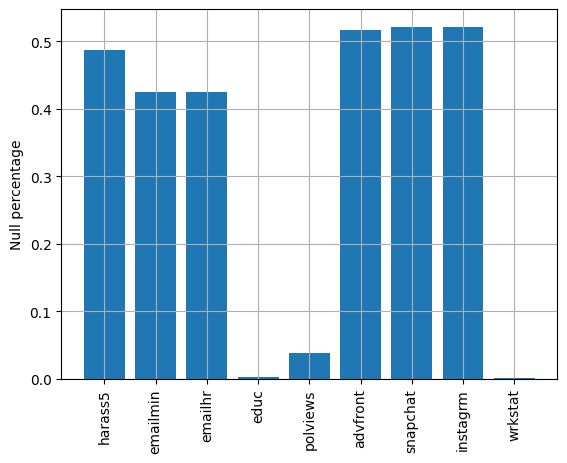

In [8]:
col_to_null_percentage = dict(zip(df.columns.tolist(), map(lambda x: df[x].isna().sum()/len(df[x]), df.columns.tolist())))

plt.bar(col_to_null_percentage.keys(), col_to_null_percentage.values())
plt.xticks(rotation=90)
plt.ylabel("Null percentage")
plt.grid()

### Xóa các dòng tương ứng là nột ở hai cột educ và wrkstat

In [9]:
columns_to_check = ['educ', 'wrkstat']
df.dropna(subset=columns_to_check, inplace=True)

### Tính tổng thời gian check email bằng emailhr $\times$ 60 + emailmin

In [10]:
df['emailtotal'] = np.where(df['emailhr'].isna() | df['emailmin'].isna(), np.nan, df['emailhr'] * 60 + df['emailmin'])
df = df.drop(['emailhr', 'emailmin'], axis=1)

In [11]:
df.shape

(2858, 8)

### Xét tập dữ liệu mà thời gian check email không null

In [12]:
df.dropna(subset=['emailtotal'], inplace=True)

### Có 1648 quan sát mà thời gian check email không bị null

In [13]:
df.shape

(1648, 8)

### Các giá trị unique trong từng trường

In [14]:
column_unique_value = {}
for col in df.columns.tolist():
    if col == 'emailtotal':
        continue
    try:
        print(col, np.unique(df[col].to_numpy()))
        column_unique_value[col] = np.unique(df[col].to_numpy())
    except:
        print(col, list(set(df[col].tolist())))
        column_unique_value[col] = list(set(df[col].tolist()))

harass5 [nan, 'No', 'Does not apply (i do not have a job/superior/co-worker)', 'Yes']
educ [ 2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
polviews [nan, 'Extrmly conservative', 'Slightly liberal', 'Extremely liberal', 'Liberal', 'Conservative', 'Moderate', 'Slghtly conservative']
advfront [nan, 'Disagree', 'Strongly disagree', 'Dont know', 'Agree', 'Strongly agree']
snapchat [nan, 'No', 'Yes']
instagrm [nan, 'No', 'Yes']
wrkstat ['Keeping house' 'Other' 'Retired' 'School' 'Temp not working'
 'Unempl, laid off' 'Working fulltime' 'Working parttime']


### Tạo dictionary ánh xạ chỉ số thành các giá trị unique (phục vụ mã hóa sau này)

In [15]:
value_to_index = {}

for col in df.columns.tolist():
    if col == 'emailtotal':
        continue
    try:
        unique_set = np.unique(df[col].to_numpy()).tolist()
        unique_set = [x for x in unique_set if not math.isnan(x)]
        print(col, unique_set)
        unique_set.sort()
        value_to_index[col] = dict(zip(unique_set, unique_set))
    except:
        #print(col, list(set(df[col].tolist())))
        unique_set = list(set(df[col].tolist()))
        chosens = []
        for i in unique_set:
            if isinstance(i, float):
                if math.isnan(i):
                    continue
            #print(type(i), i)
            chosens.append(i)
        unique_set = chosens
        
        print(col, unique_set)
        unique_set.sort()
    
        if col == "advfront":
            value_to_index[col] = {'Strongly disagree': 1, 'Disagree': 2, 'Dont know': 3, 'Agree': 4, 'Strongly agree': 5}
        elif col == "polviews":
            value_to_index[col] = {'Extrmly conservative': 1, 'Conservative': 2, 'Slghtly conservative': 3, 'Moderate': 4, 'Slightly liberal': 5, 'Liberal': 6, 'Extremely liberal': 7}
        elif col == "educ" or col == "wrkstat":
            value_to_index[col] = dict(zip(unique_set, range(len(unique_set))))
        else:
            value_to_index[col] = dict(zip(unique_set, range(1, len(unique_set) + 1)))
        
print(value_to_index)

harass5 ['No', 'Does not apply (i do not have a job/superior/co-worker)', 'Yes']
educ [2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
polviews ['Extrmly conservative', 'Slightly liberal', 'Extremely liberal', 'Liberal', 'Conservative', 'Moderate', 'Slghtly conservative']
advfront ['Disagree', 'Strongly disagree', 'Dont know', 'Agree', 'Strongly agree']
snapchat ['No', 'Yes']
instagrm ['No', 'Yes']
wrkstat ['Other', 'Keeping house', 'School', 'Temp not working', 'Working parttime', 'Retired', 'Working fulltime', 'Unempl, laid off']
{'harass5': {'Does not apply (i do not have a job/superior/co-worker)': 1, 'No': 2, 'Yes': 3}, 'educ': {2.0: 2.0, 4.0: 4.0, 5.0: 5.0, 6.0: 6.0, 7.0: 7.0, 8.0: 8.0, 9.0: 9.0, 10.0: 10.0, 11.0: 11.0, 12.0: 12.0, 13.0: 13.0, 14.0: 14.0, 15.0: 15.0, 16.0: 16.0, 17.0: 17.0, 18.0: 18.0, 19.0: 19.0, 20.0: 20.0}, 'polviews': {'Extrmly conservative': 1, 'Conservative': 2, 'Slghtly conservative': 3, 'Moderate': 4, '

### Số lần xuất hiện tương ứng với từng giá trị unique của từng trường

C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\883285278.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\883285278.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\883285278.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\883285278.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\883285278.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


Max email minute: 6000.0


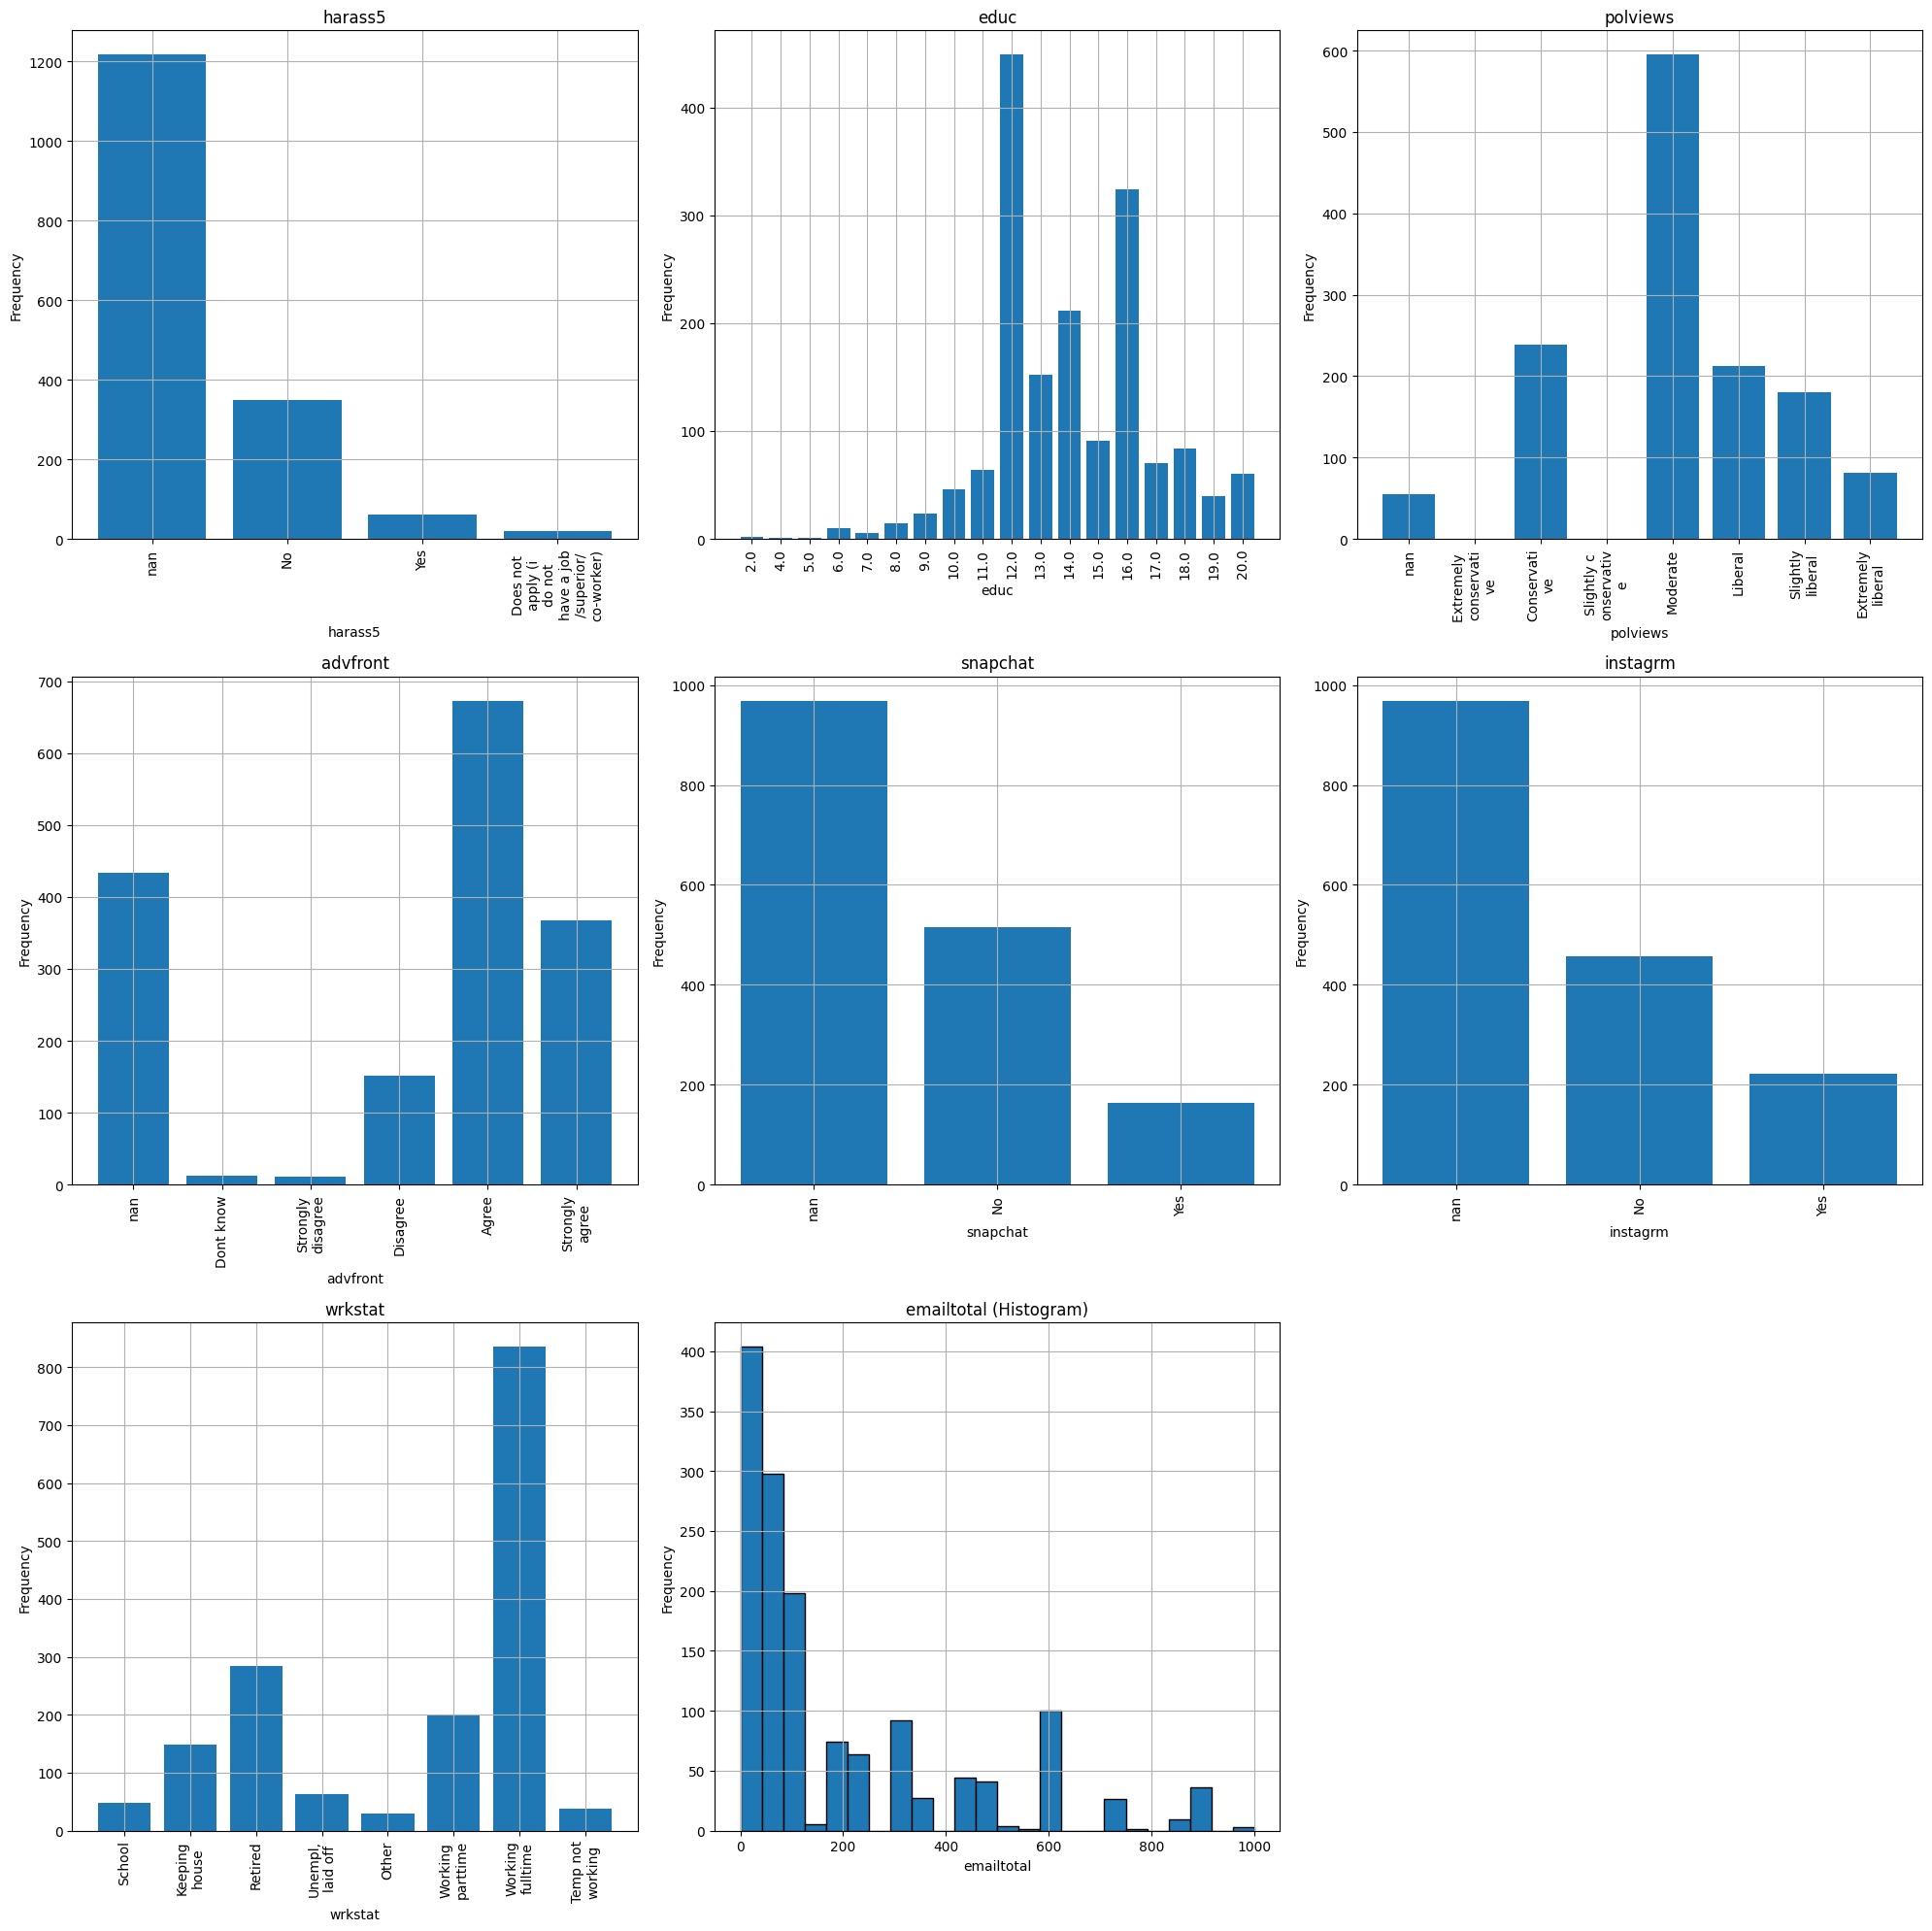

In [16]:
column_unique_value['harass5'] = [float('nan'), 'No', 'Yes', 'Does not apply (i do not have a job/superior/co-worker)']
column_unique_value['polviews'] = [float('nan'), 'Extremely conservative', 'Conservative', 'Slightly conservative', 'Moderate', 'Liberal',
                  'Slightly liberal', 'Extremely liberal']
column_unique_value['advfront'] = [float('nan'), 'Dont know', 'Strongly disagree', 'Disagree', 'Agree', 'Strongly agree']
column_unique_value['snapchat'] = [float('nan'), 'No', 'Yes']
column_unique_value['instagrm'] = [float('nan'), 'No', 'Yes']
column_unique_value['wrkstat'] = [float('nan'), 'School', 'Keeping house', 'Retired', 'Unempl, laid off', 'Other',
                 'Working parttime', 'Working fulltime', 'Temp not working']

# Get the list of categorical columns
categorical_columns = df.columns.tolist()

# Calculate the number of rows and columns needed for subplots
num_rows = (len(categorical_columns) + 2) // 3
num_cols = min(len(categorical_columns), 3)

# Create subplots
fig = plt.figure(figsize=(20, 20), facecolor='w')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)


# Loop through each categorical column and create the bar plot
for i, column in enumerate(categorical_columns):
    # Count the occurrences of each value (including NaN) in the column
    #sns.countplot(x=column, data=df, ax=axes[i])
    #print("Column {}".format(column))
    axes = fig.add_subplot(num_rows, num_cols, i + 1)
    if column == 'emailtotal':
        # Create a histogram for 'emailtotal'
        bins = np.linspace(0, 1000, 25)
        print("Max email minute: {}".format(np.max(df['emailtotal'])))
        axes.hist(df[column], bins=bins, edgecolor='black')
        axes.set_xlabel(column)
        axes.set_ylabel("Frequency")
        axes.set_title(f"{column} (Histogram)")
        axes.grid()
    else:
        value_counts = df[column].value_counts(dropna=False, sort=False).sort_index()
        custom_order = column_unique_value.get(column, value_counts.index)
        value_counts = value_counts.reindex(custom_order)
        axes.bar(value_counts.index.astype(str), value_counts.values)
        wrapped_labels = [textwrap.fill(label, 10) for label in value_counts.index.astype(str)]
        axes.set_xticklabels(wrapped_labels, rotation=90, ha="center")
        # Set the plot labels and title for the current subplot
        axes.set_xlabel(column)
        axes.set_ylabel("Frequency")
        axes.set_title(f"{column}")
        axes.grid()

# Hide any empty subplots if needed
#if len(categorical_columns) % 3 != 0:
#    for i in range(len(categorical_columns) % 3, 3):
#        fig.delaxes(axes[-i - 1])
#
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Tính bảng tần suất đồng xuất hiện của các trường categorical với trường wrkstat

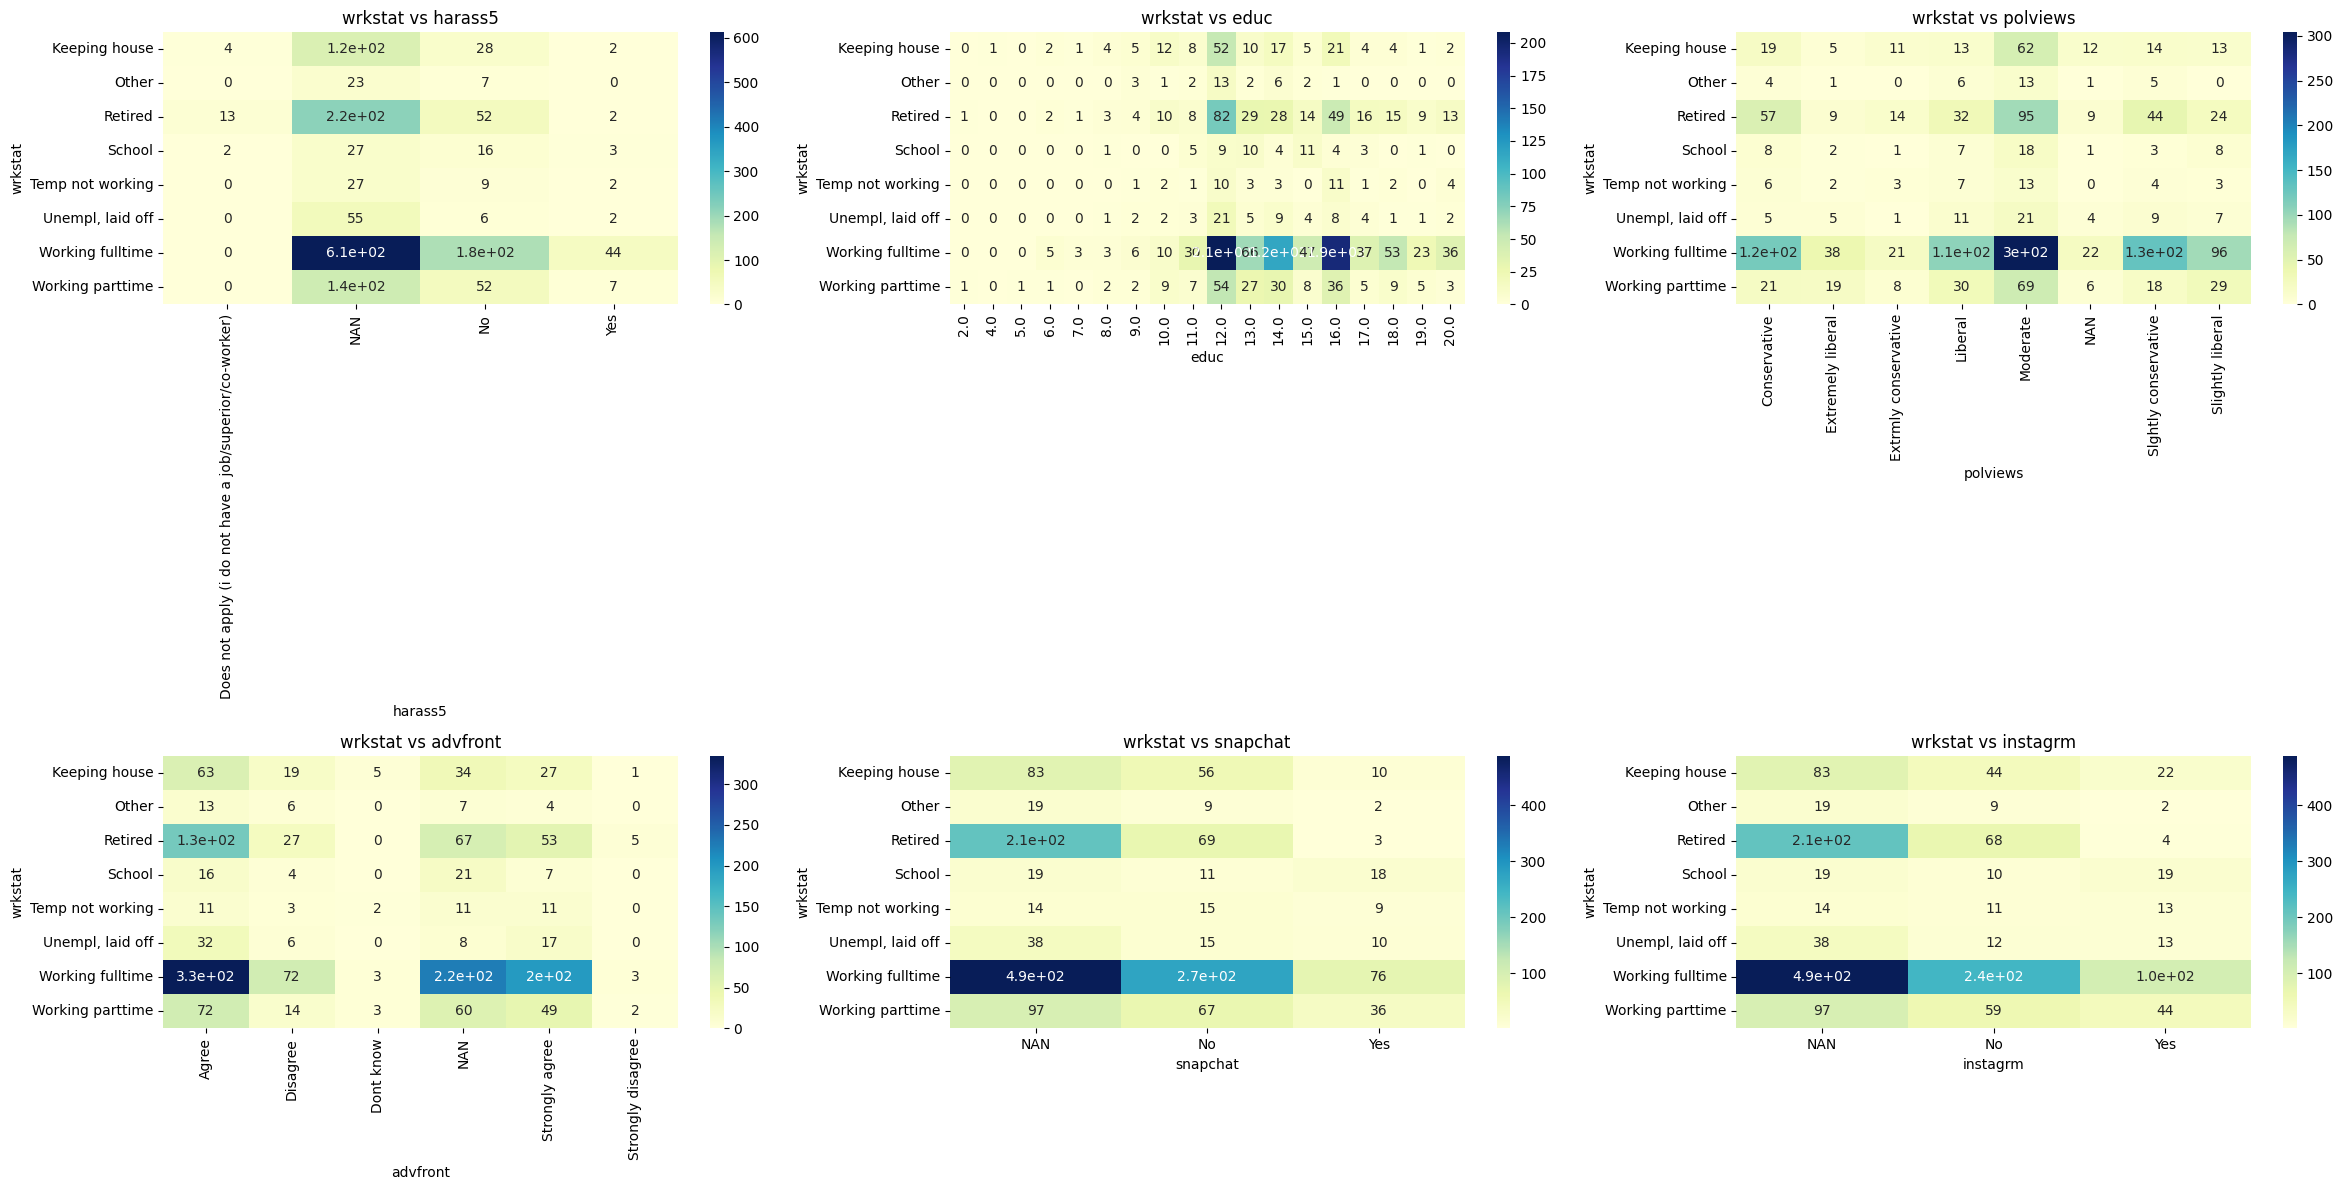

In [17]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

df_filled = df.copy()
for column in considered_columns:
    df_filled[column] = df_filled[column].fillna('NAN')

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df_filled['wrkstat'], df_filled[column])
    # Plot the heatmap in the current subplot
    sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'wrkstat vs {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()

for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

### Tính bảng tỷ lệ của các giá trị unique của các trường categorical khi cố định từng giá trị của trường wrkstat

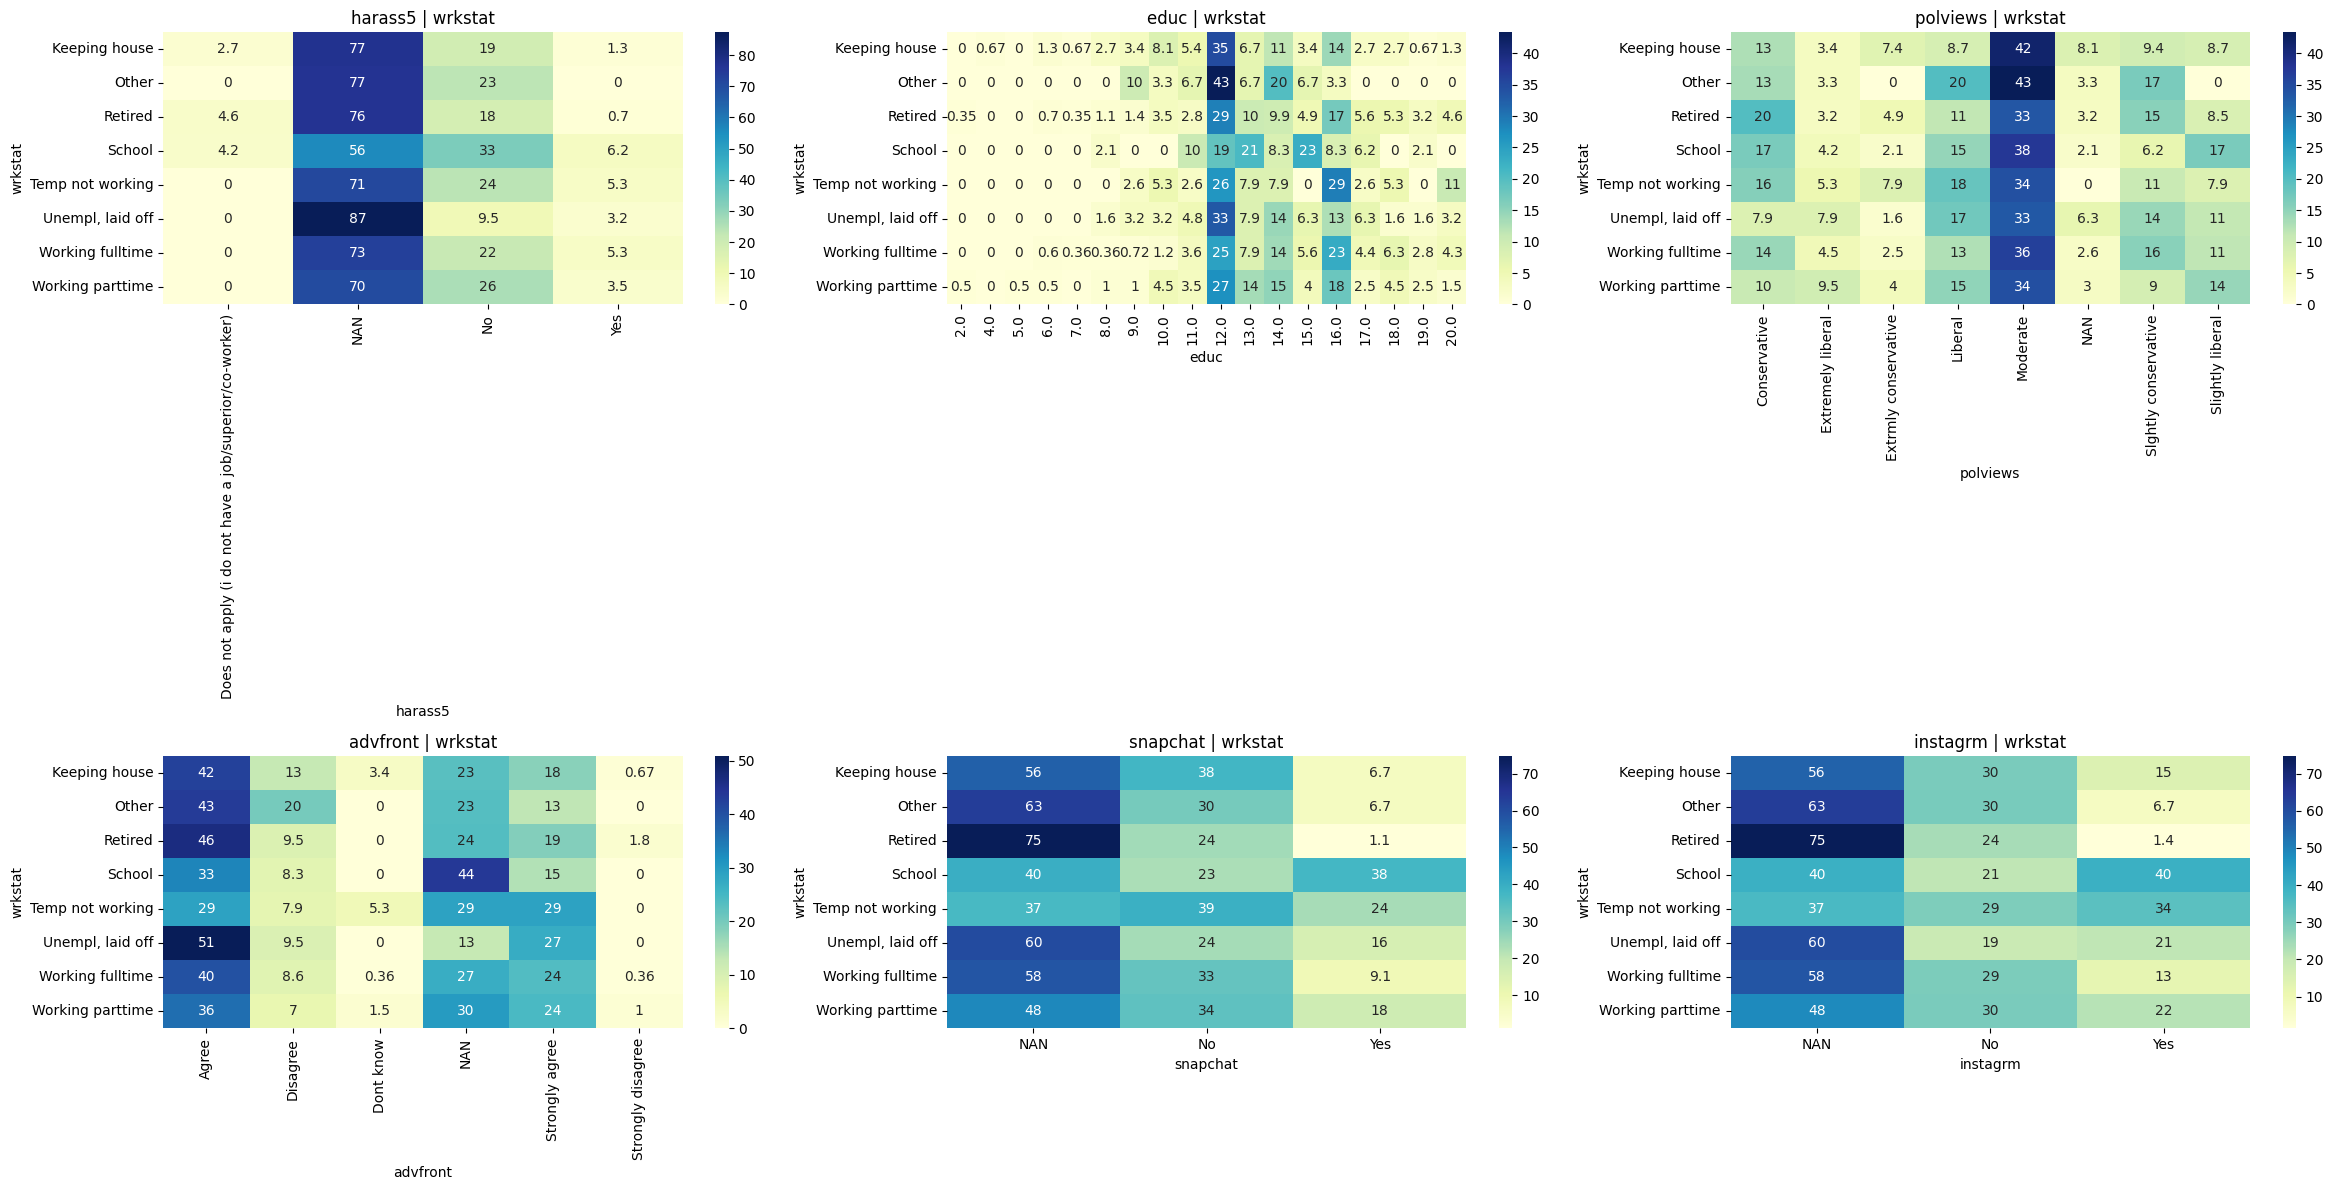

In [18]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

df_filled = df.copy()
for column in considered_columns:
    df_filled[column] = df_filled[column].fillna('NAN')

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df_filled['wrkstat'], df_filled[column])
    percentages = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=1), axis=0) * 100
    # Plot the heatmap in the current subplot
    sns.heatmap(percentages, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'{column} | wrkstat')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()
    
for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

### Tính bảng tỷ lệ của các giá trị unique của trường wrkstat khi cố định từng giá trị của các trường categorical

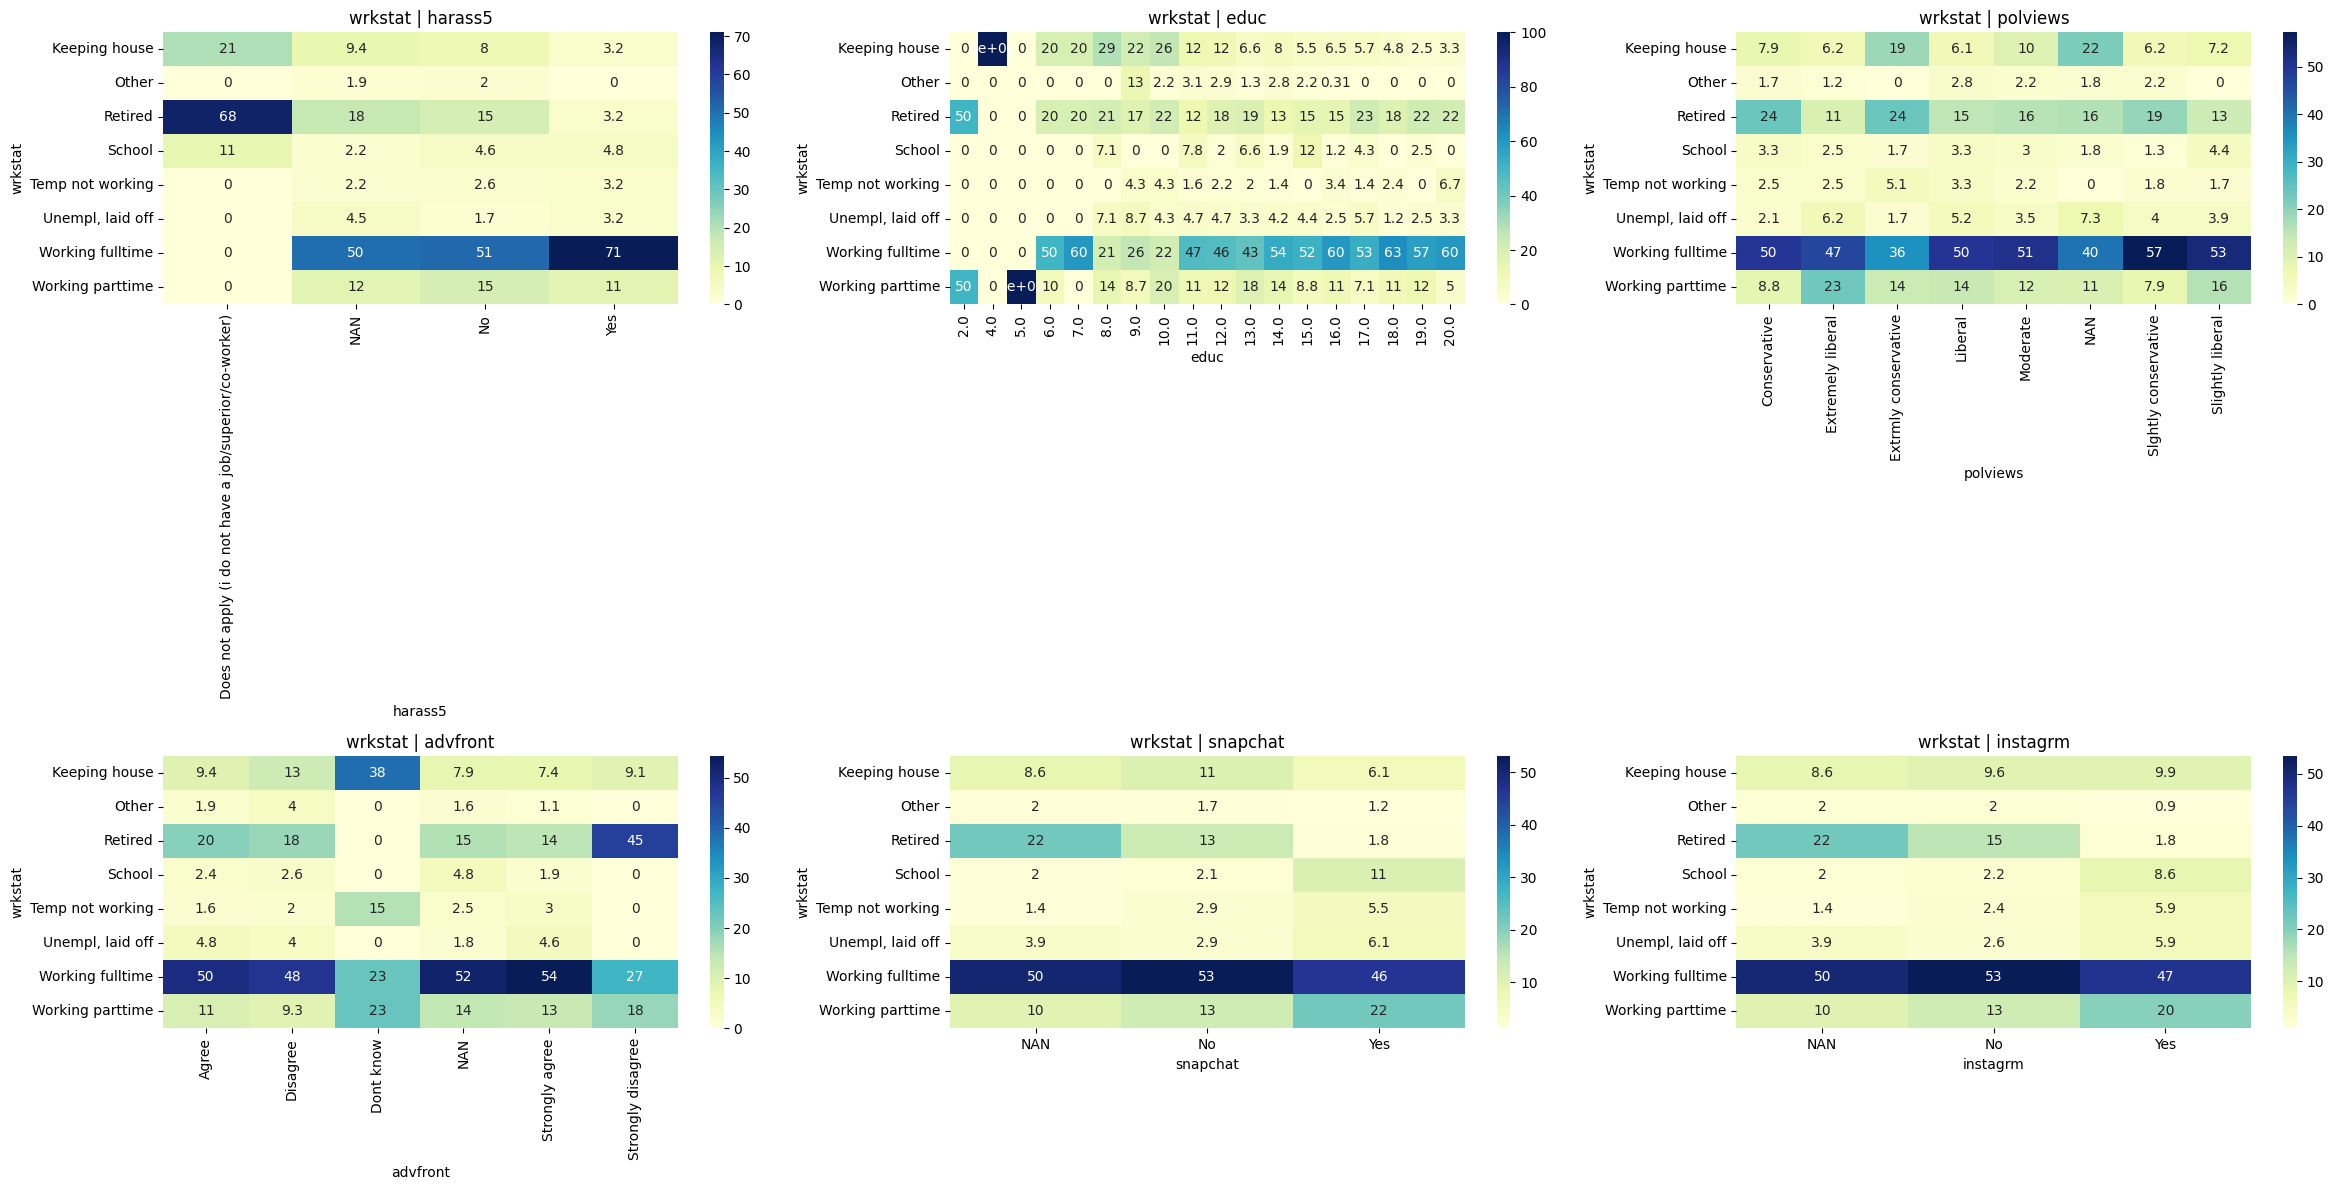

In [19]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

df_filled = df.copy()
for column in considered_columns:
    df_filled[column] = df_filled[column].fillna('NAN')

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df_filled['wrkstat'], df_filled[column])
    percentages = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=0), axis=1) * 100
    # Plot the heatmap in the current subplot
    sns.heatmap(percentages, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'wrkstat | {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()
    
for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

### Boxplot của thời gian check email đối với từng giá trị unique của trường wrkstat

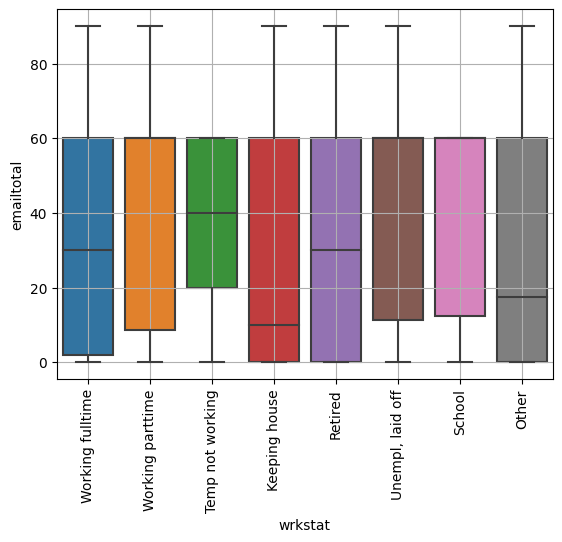

In [20]:
df_box = df[df.emailtotal < 100]
sns.boxplot(data=df_box, x="wrkstat", y="emailtotal")
plt.xticks(rotation=90)
plt.grid()

### Dùng chi square test để kiểm tra tính độc lập của trường wrkstat với từng trường categorical còn lại

In [21]:
considered = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm']

df_filled = df.copy()
for column in considered_columns:
    df_filled[column] = df_filled[column].fillna('NAN')

p_value = {}

for col in considered:
    contingency_table = pd.crosstab(df_filled['wrkstat'], df_filled[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_value[col] = p
    #contingency_table, chi2, p, dof, expected
    
p_value

{'harass5': 4.4925978347904565e-09,
 'educ': 2.1928135948777916e-07,
 'polviews': 0.0024219542491431397,
 'advfront': 0.00024738374531961847,
 'snapchat': 2.8930041730139435e-18,
 'instagrm': 7.175435003461458e-17}

### Encode các trường categorical thành dạng số nguyên

In [22]:
for col in df.columns.tolist():
    if col == 'emailtotal' or col == "wrkstat":
        continue
    df[col] = df[col].map(value_to_index[col])

In [23]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,NaN,16.0,4.0,5.0,NaN,NaN,Working fulltime,720.0
1,NaN,12.0,6.0,2.0,1.0,1.0,Working fulltime,30.0
3,NaN,12.0,4.0,2.0,NaN,NaN,Working parttime,10.0
5,NaN,14.0,5.0,5.0,1.0,2.0,Keeping house,120.0
6,NaN,14.0,5.0,5.0,NaN,NaN,Working fulltime,2400.0
...,...,...,...,...,...,...,...,...
2860,NaN,13.0,4.0,4.0,NaN,NaN,Retired,60.0
2862,NaN,20.0,7.0,4.0,1.0,2.0,Working fulltime,1200.0
2863,NaN,15.0,2.0,2.0,NaN,NaN,Working fulltime,120.0
2864,2.0,14.0,4.0,NaN,NaN,NaN,Keeping house,0.0


In [24]:
np.max(df["educ"])

20.0

### Biến các giá trị null của các trường categorical thành 0, riêng trường educ thành 21

In [25]:
categorical_columns = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']

df[categorical_columns] = df[categorical_columns].fillna(0)

df['educ'] = df['educ'].fillna(21)

#df['emailtotal'] = df['emailtotal'].fillna(0)


In [26]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,0.0,16.0,4.0,5.0,0.0,0.0,Working fulltime,720.0
1,0.0,12.0,6.0,2.0,1.0,1.0,Working fulltime,30.0
3,0.0,12.0,4.0,2.0,0.0,0.0,Working parttime,10.0
5,0.0,14.0,5.0,5.0,1.0,2.0,Keeping house,120.0
6,0.0,14.0,5.0,5.0,0.0,0.0,Working fulltime,2400.0
...,...,...,...,...,...,...,...,...
2860,0.0,13.0,4.0,4.0,0.0,0.0,Retired,60.0
2862,0.0,20.0,7.0,4.0,1.0,2.0,Working fulltime,1200.0
2863,0.0,15.0,2.0,2.0,0.0,0.0,Working fulltime,120.0
2864,2.0,14.0,4.0,0.0,0.0,0.0,Keeping house,0.0


### Chuyển các giá trị thành dạng int

In [27]:
#df["wrkstat"] = df["wrkstat"].astype(np.int16)
casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm', 'emailtotal']
#casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm']
#casted_columns = ['emailtotal']

for col in casted_columns:
    df[col] = df[col].astype(np.int16)

In [28]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,0,16,4,5,0,0,Working fulltime,720
1,0,12,6,2,1,1,Working fulltime,30
3,0,12,4,2,0,0,Working parttime,10
5,0,14,5,5,1,2,Keeping house,120
6,0,14,5,5,0,0,Working fulltime,2400
...,...,...,...,...,...,...,...,...
2860,0,13,4,4,0,0,Retired,60
2862,0,20,7,4,1,2,Working fulltime,1200
2863,0,15,2,2,0,0,Working fulltime,120
2864,2,14,4,0,0,0,Keeping house,0


### One hot encoding các trường categorical

In [29]:
categorical_columns = ['harass5', 'snapchat', 'instagrm', 'polviews', 'advfront', 'educ']
numerical_columns = ['emailtotal']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [30]:
#df_encoded.dropna(subset=['emailtotal'], inplace=True)

In [31]:
#df_encoded['emailtotal'] = df_encoded['emailtotal'].astype(np.int16)

### Chuẩn hóa trường thời gian check email

In [32]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
#df_encoded = scaler.fit_transform(df_encoded)

df_encoded

,wrkstat,emailtotal,harass5_0,harass5_1,harass5_2,harass5_3,snapchat_0,snapchat_1,snapchat_2,instagrm_0,...,educ_11,educ_12,educ_13,educ_14,educ_15,educ_16,educ_17,educ_18,educ_19,educ_20
0,Working fulltime,0.445574,1,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,Working fulltime,-0.568931,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Working parttime,-0.598337,1,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,Keeping house,-0.436604,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
6,Working fulltime,2.915674,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,Retired,-0.524822,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2862,Working fulltime,1.151317,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2863,Working fulltime,-0.436604,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2864,Keeping house,-0.613040,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


### Tạo tập dữ liệu dạng numpy array và thực hiện PCA

In [33]:
y = df_encoded["wrkstat"]
y = y.to_numpy()

x = df_encoded.drop("wrkstat", axis=1).to_numpy()
U, reduced_x = pca(x=x, alpha=0.45)

# pca = PCA(n_components=3)
# pca.fit(x)
# reduced_x = pca.transform(x)

x.shape, y, reduced_x

((1648, 43),
 array(['Working fulltime', 'Working fulltime', 'Working parttime', ...,
        'Working fulltime', 'Keeping house', 'Working fulltime'],
       dtype=object),
 array([[ 0.76516265, -1.16874744, -0.15042556],
        [ 0.0738515 ,  0.73155778,  1.01875332],
        [ 1.41275401, -0.15268227, -0.10413859],
        ...,
        [ 1.26932849, -0.34444335, -0.12803762],
        [ 0.61683124,  0.36932971, -1.26404303],
        [ 1.47759915, -0.40272091,  0.23605025]]))

### Xây dựng dendrogram cho tập dữ liệu

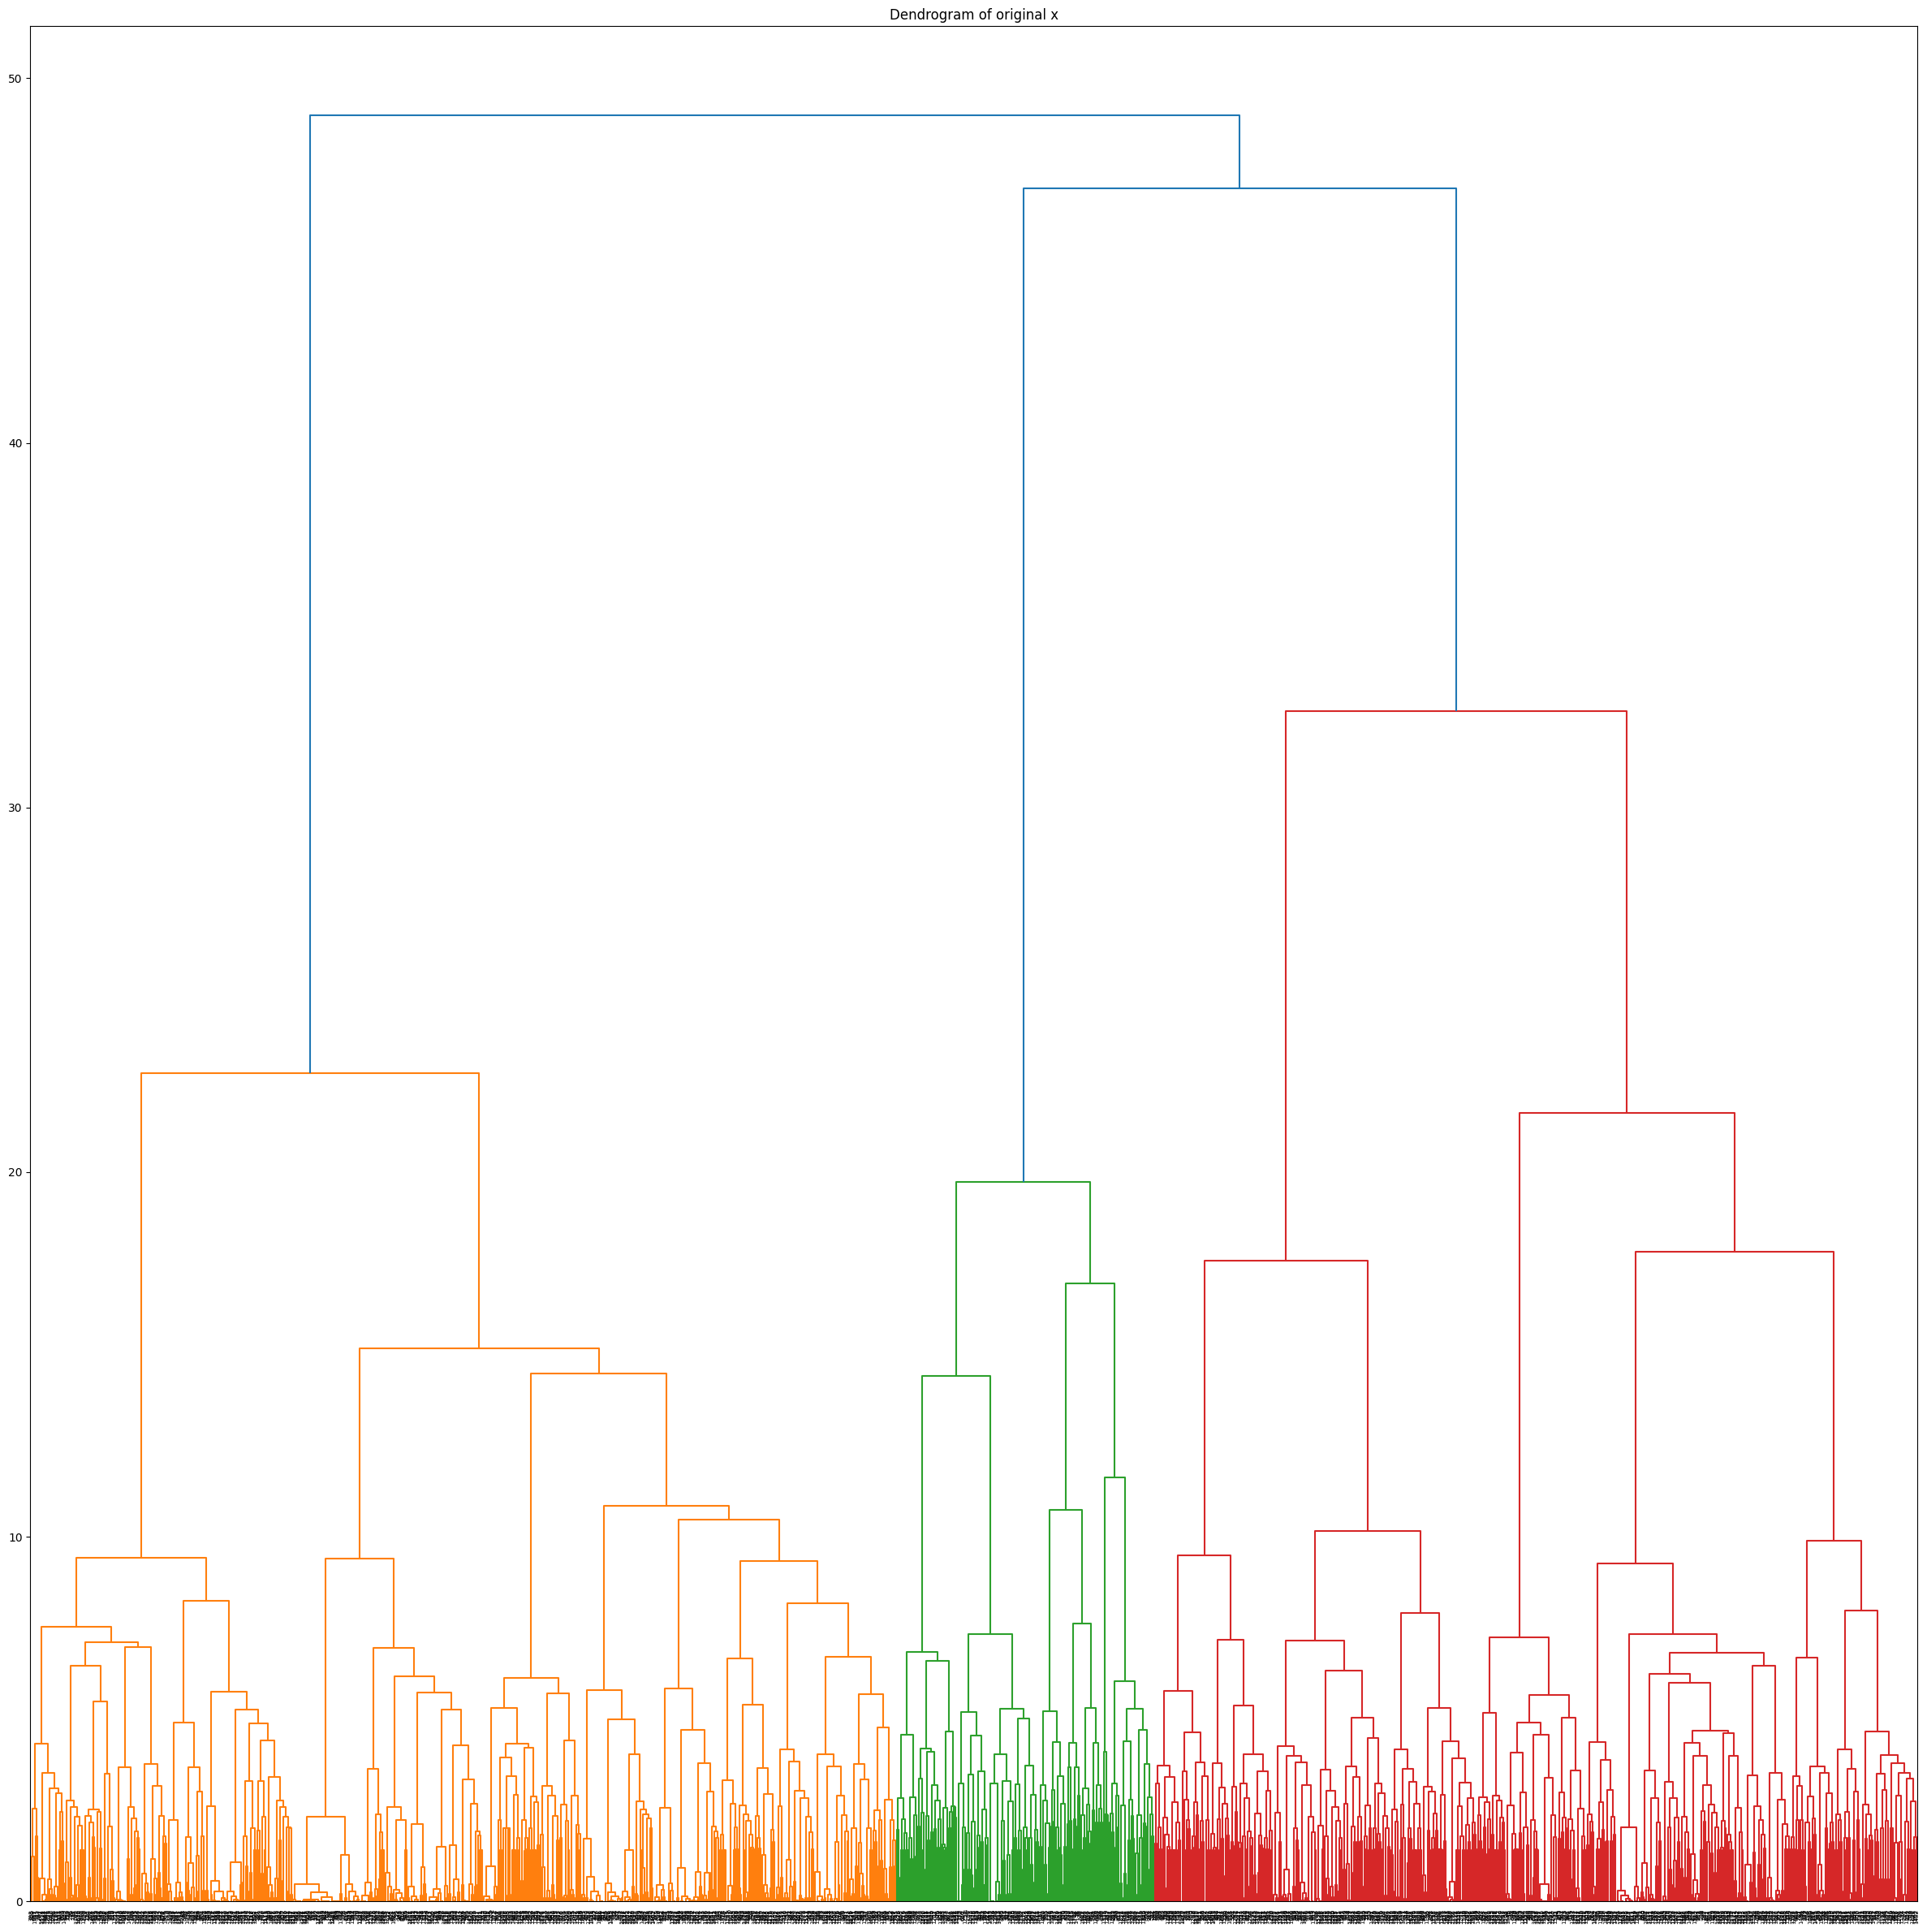

In [34]:
z = hierarchy.linkage(x, "ward")
plt.figure(figsize=(30, 30))
plt.title("Dendrogram of original x")
dn = hierarchy.dendrogram(z)

### Xây dựng dendrogram cho tập dữ liệu sau khi được phân tích PCA

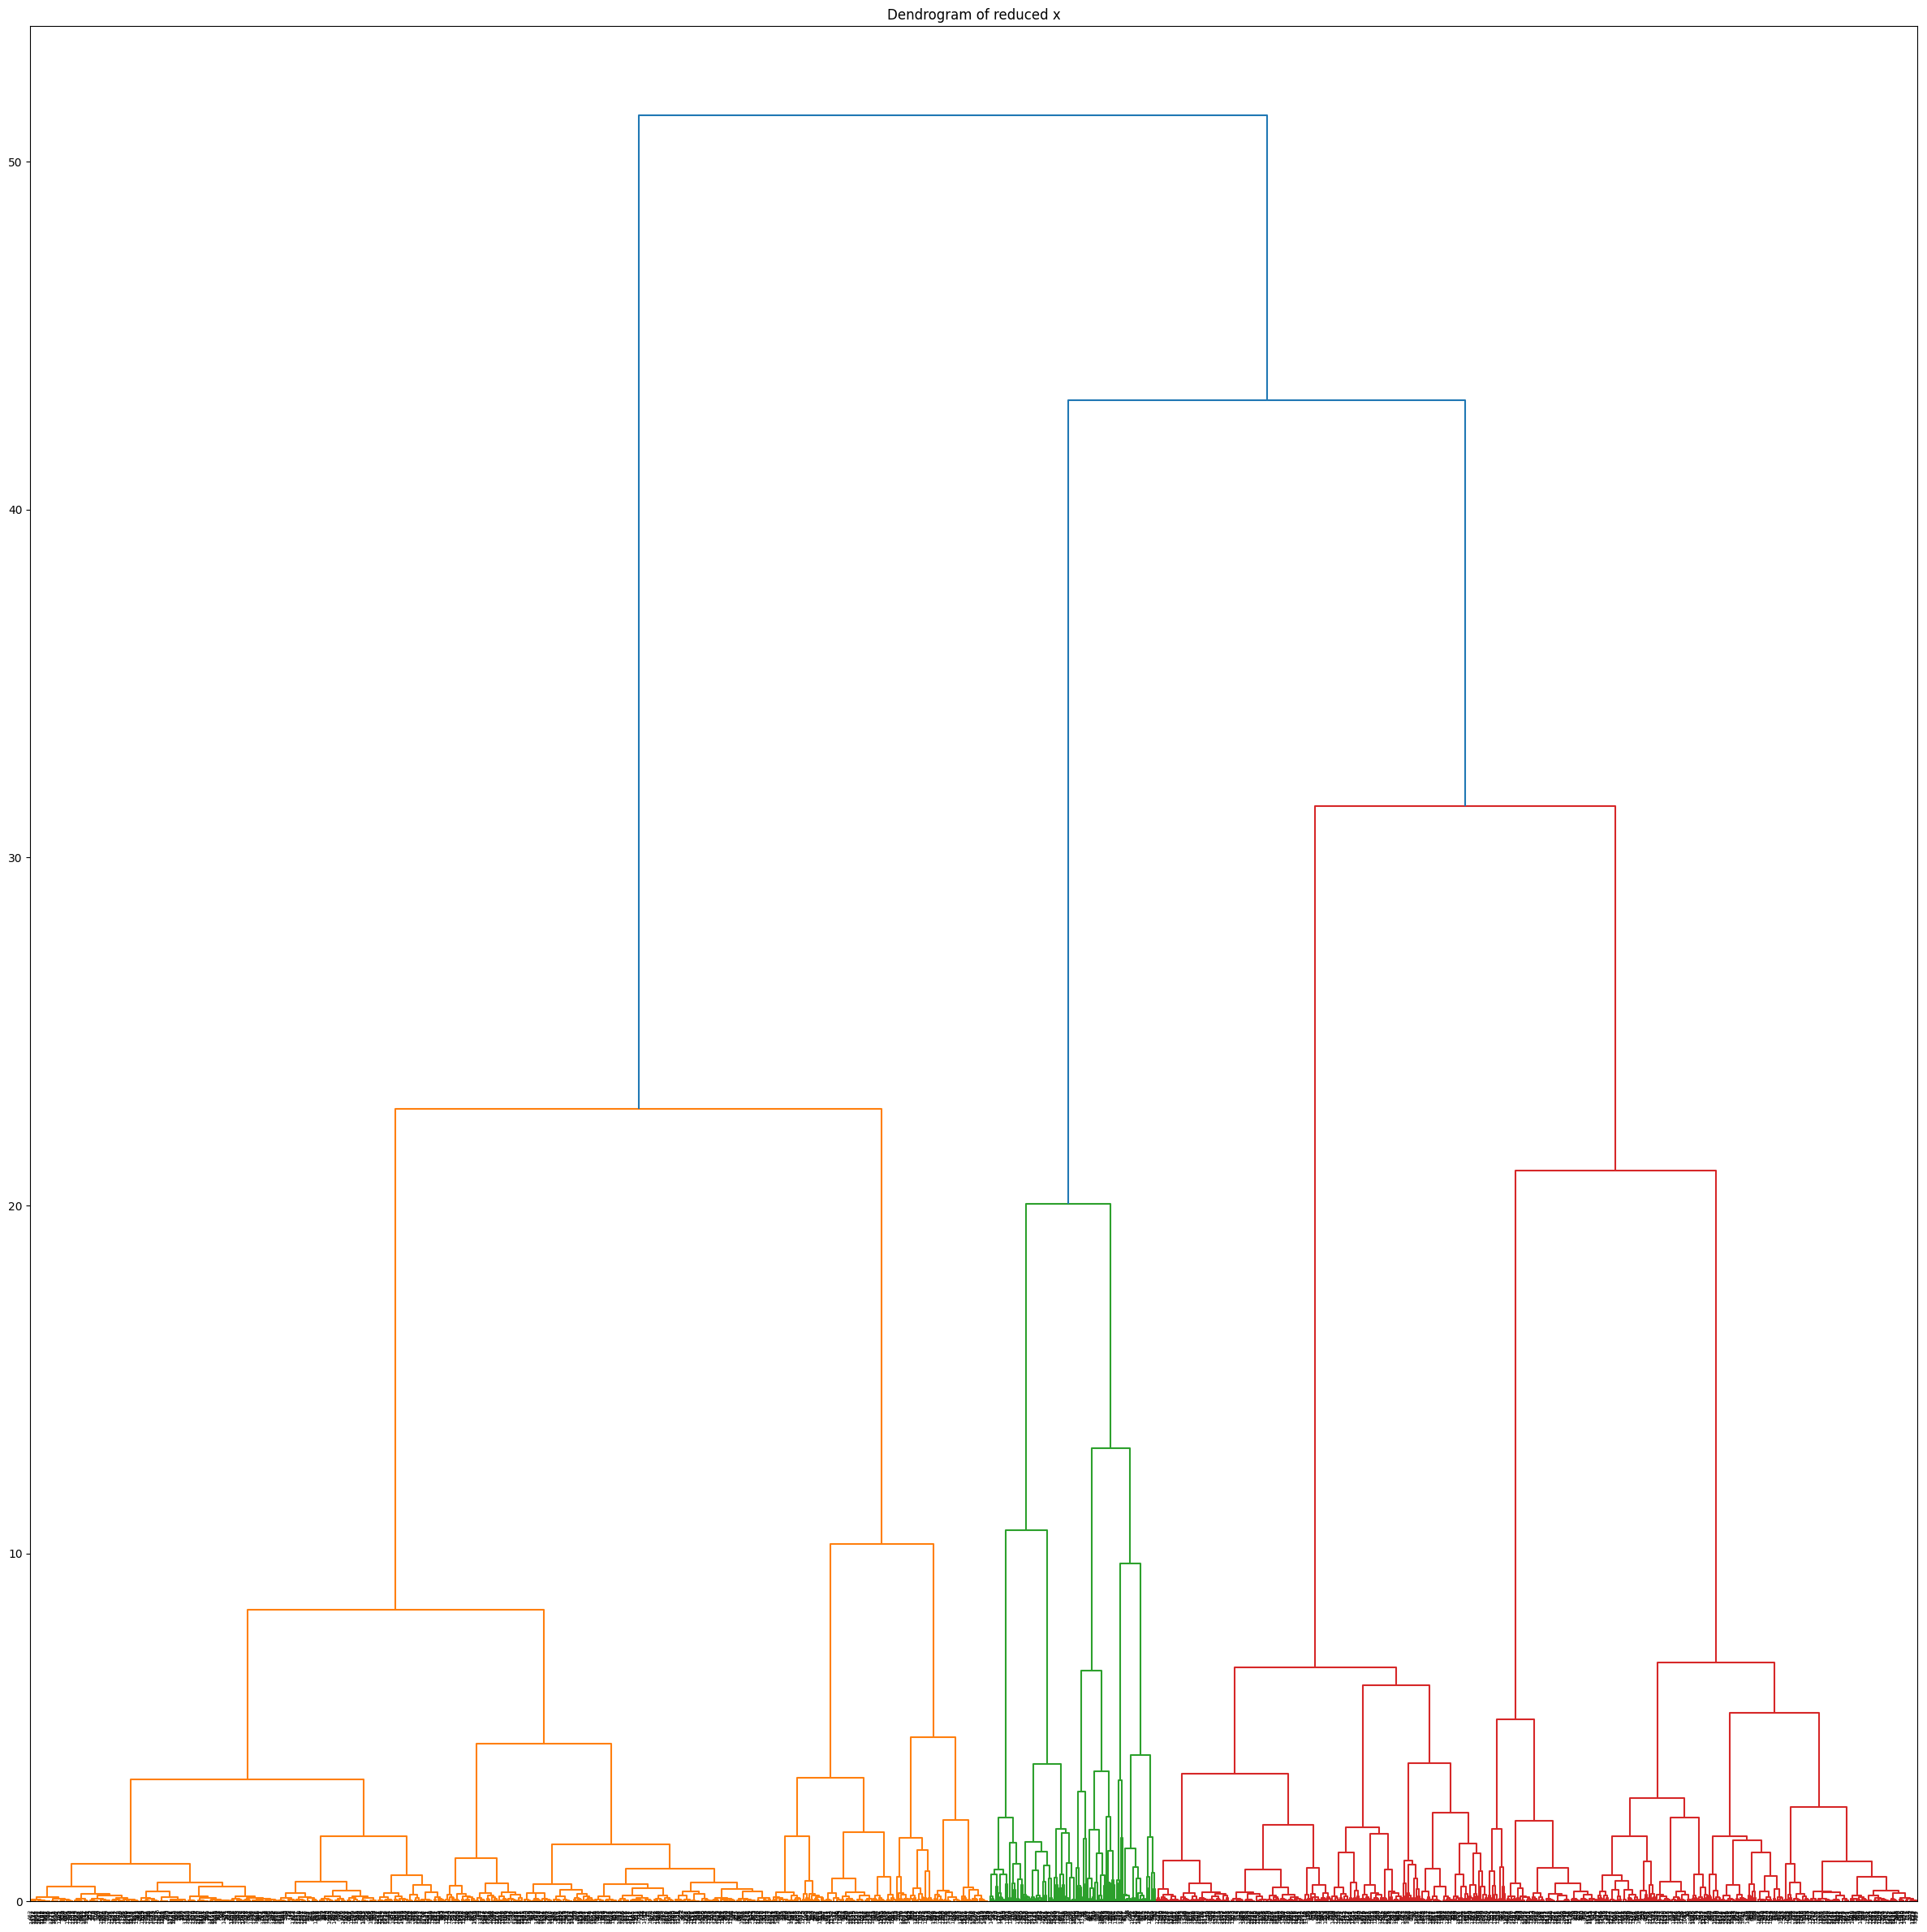

In [35]:
reduced_z = hierarchy.linkage(reduced_x, "ward")
plt.figure(figsize=(30, 30))
plt.title("Dendrogram of reduced x")
dn = hierarchy.dendrogram(reduced_z)

## Vẽ histogram của các thành phần chính với kích thước bin khác nhau

### Histogram của thành phần chính 0

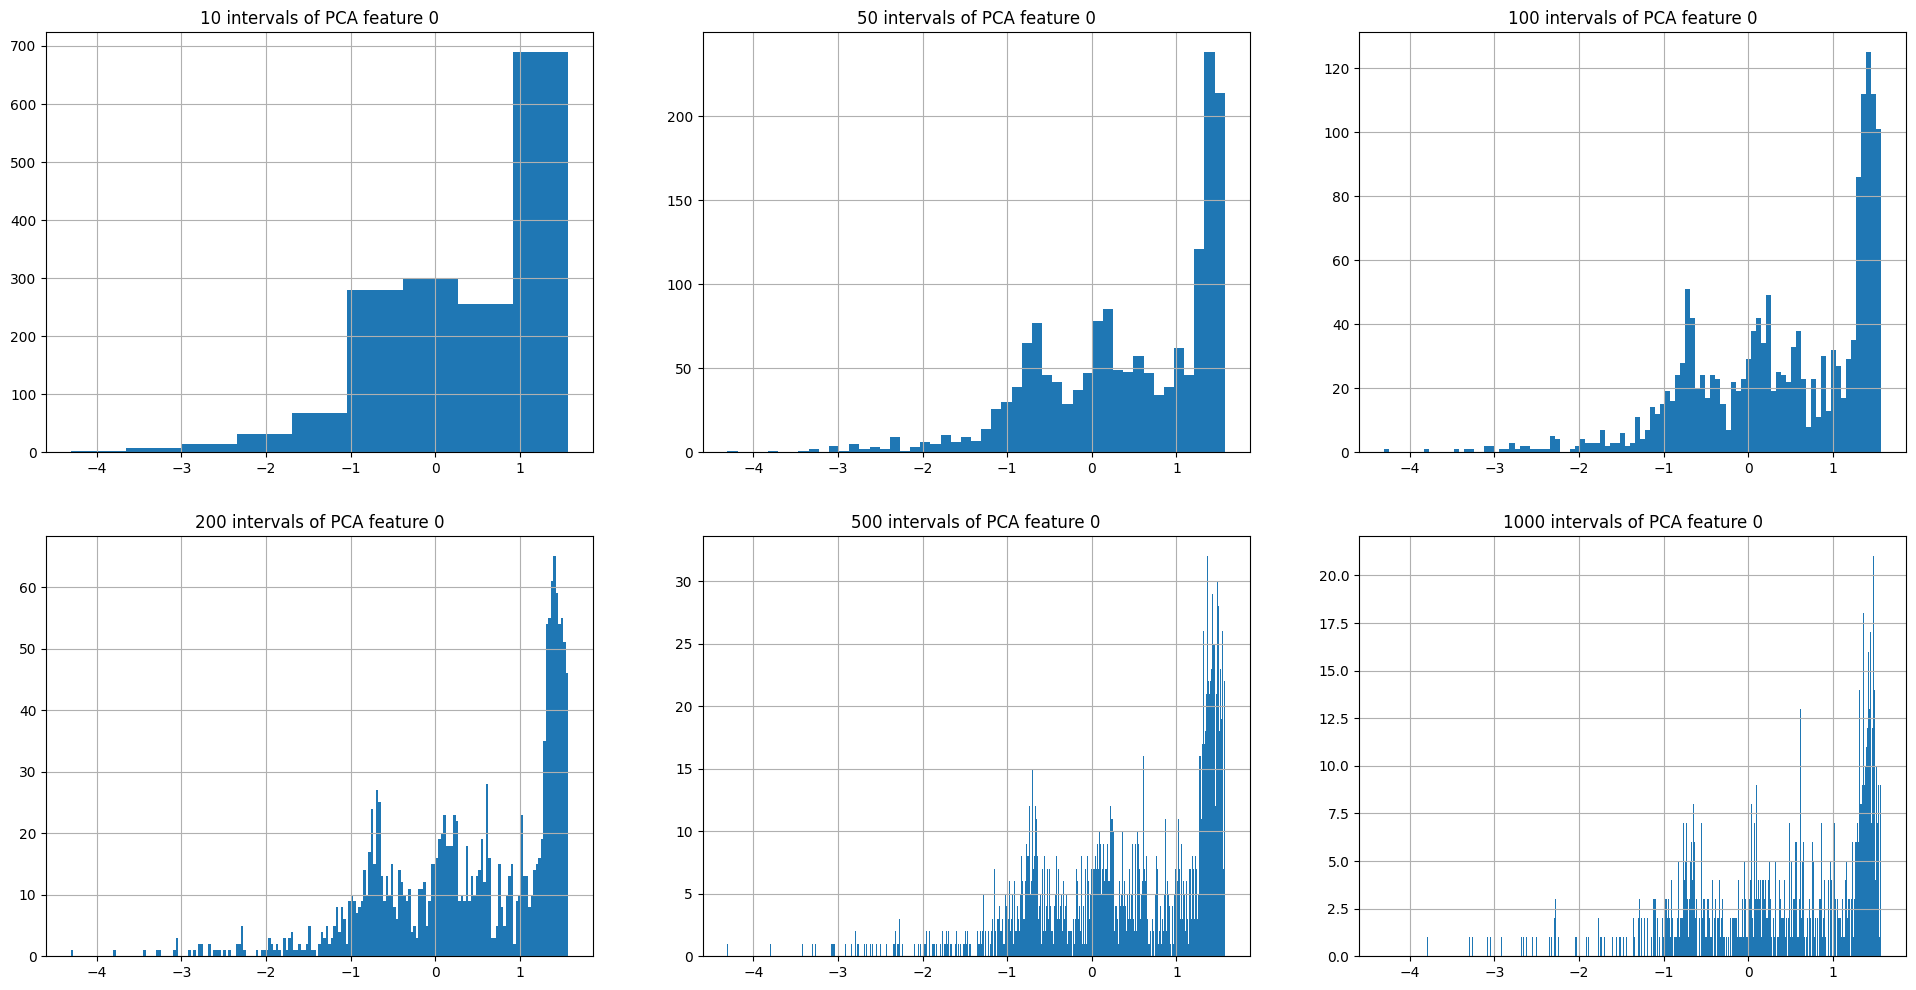

In [36]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])

num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 0

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

### Histogram của thành phần chính 1

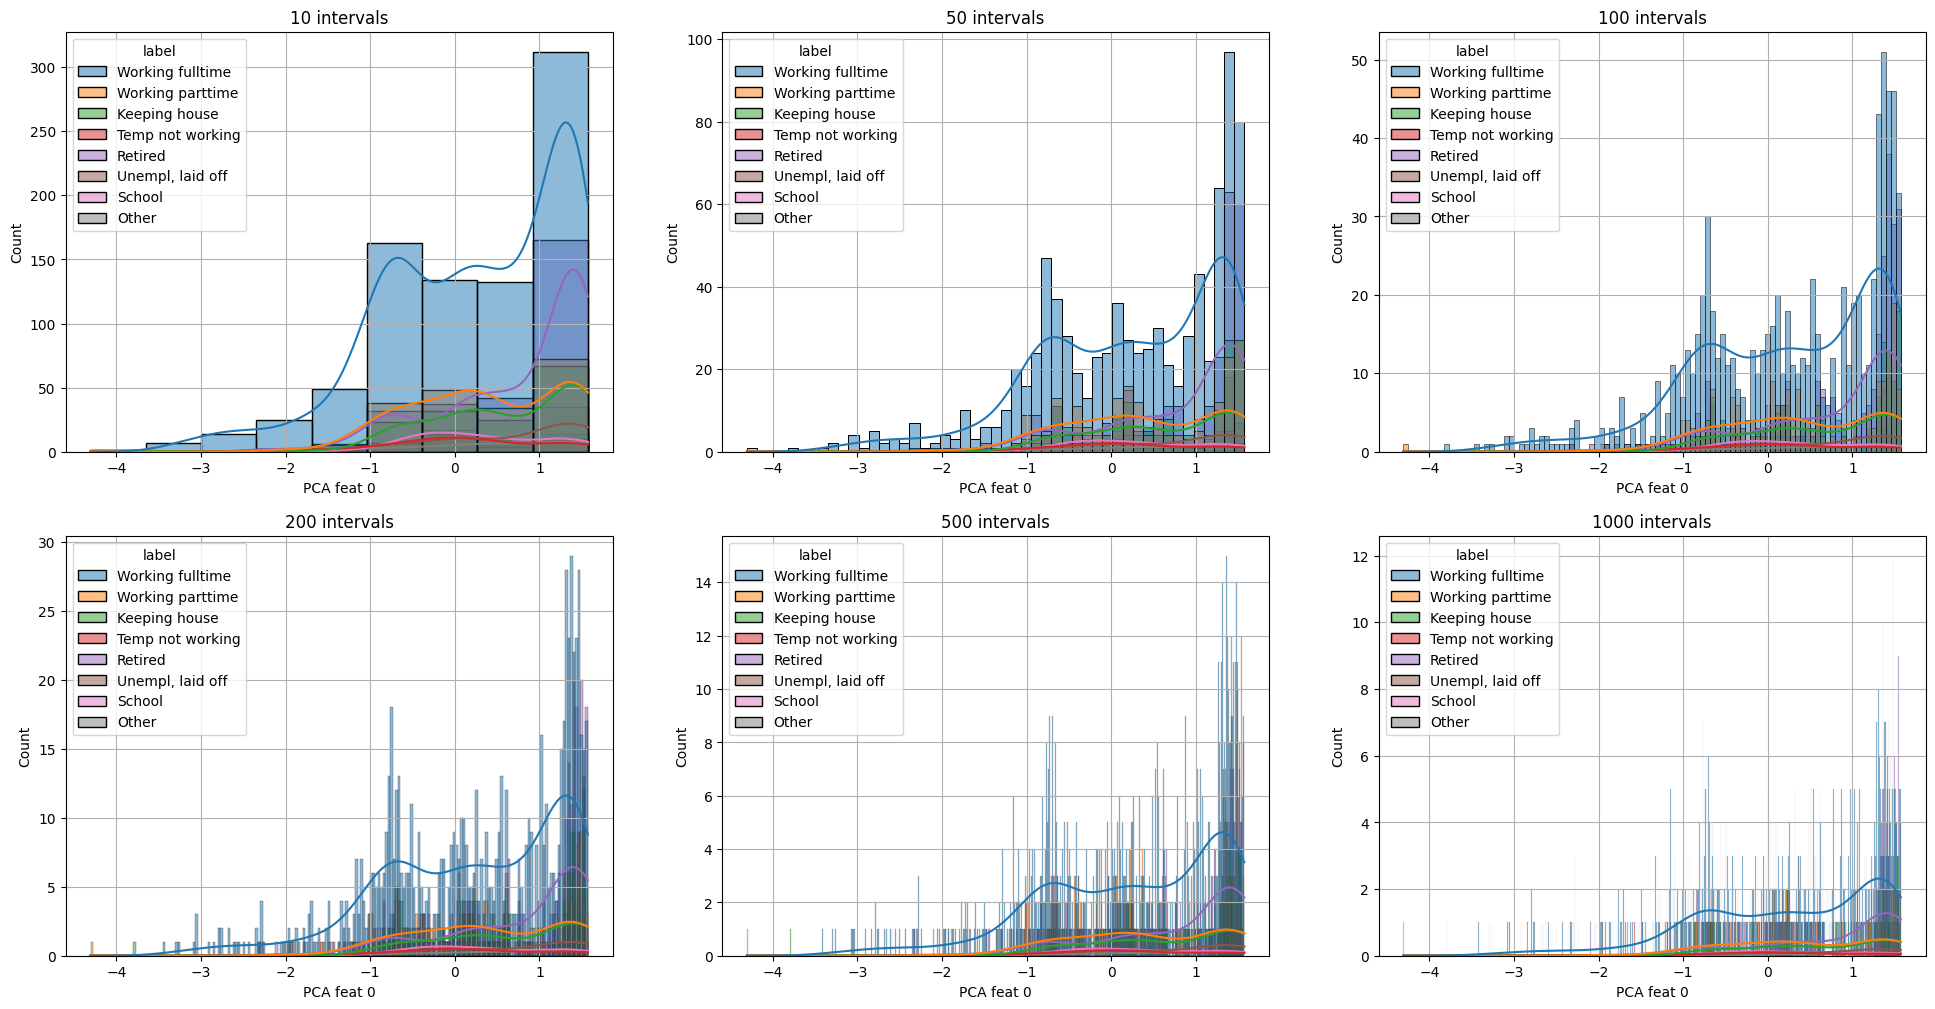

In [37]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 0

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])


### Histogram của thành phần chính 2

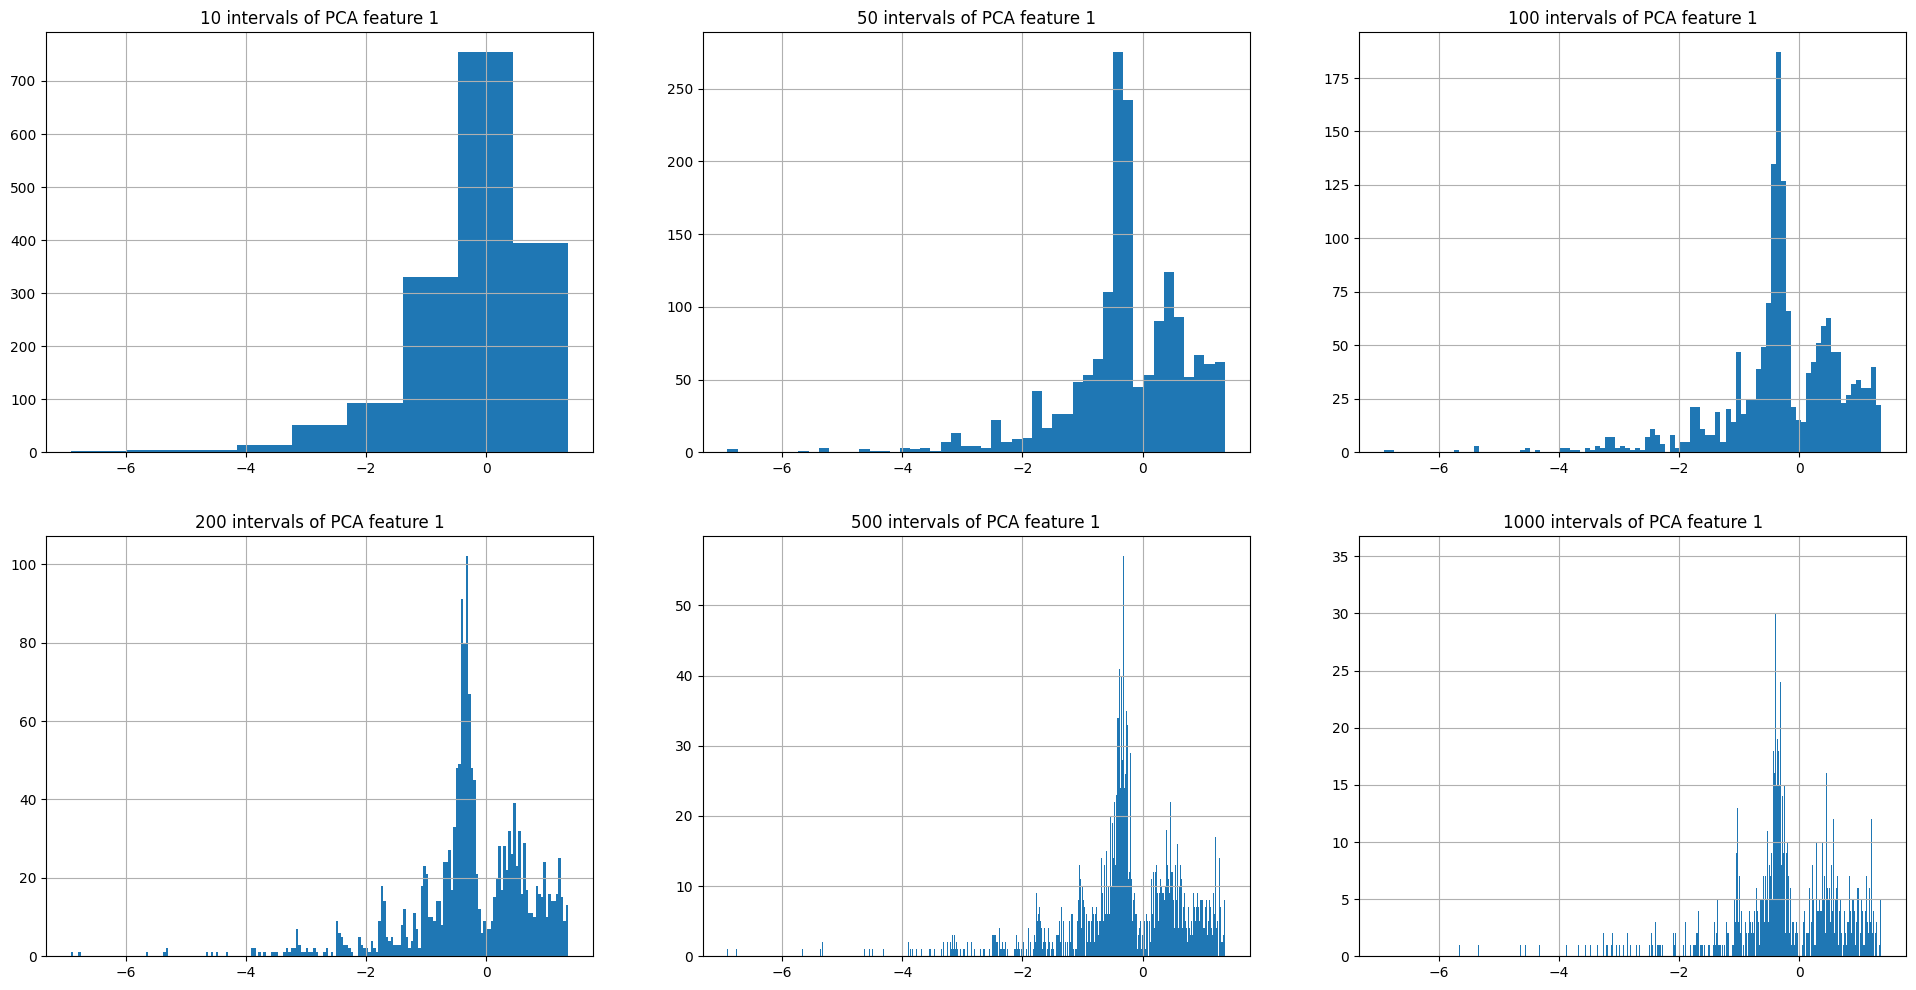

In [38]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 1

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

## Vẽ histogram và phân phối của các thành phần chính tương ứng với từng giá trị dữ liệu trong trường wrkstat

### Thành phần chính 0

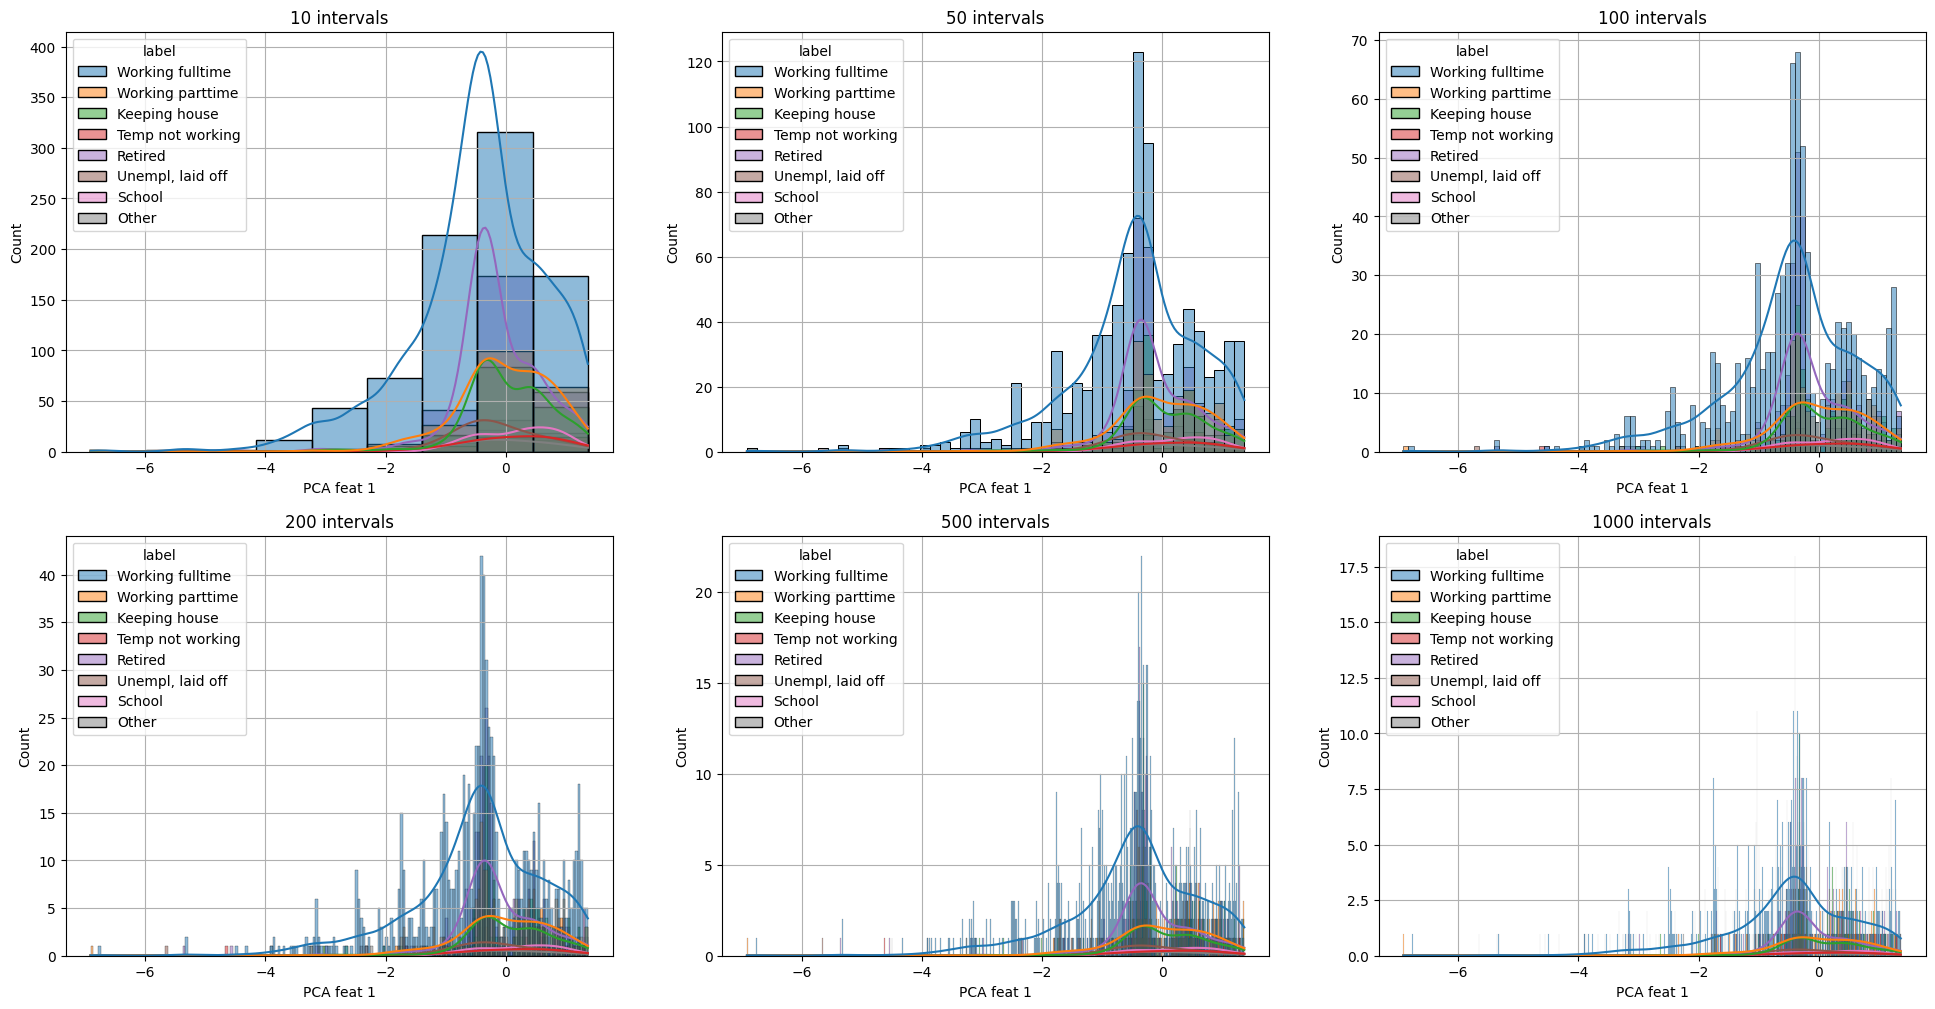

In [39]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 1

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

### Thành phần chính 1

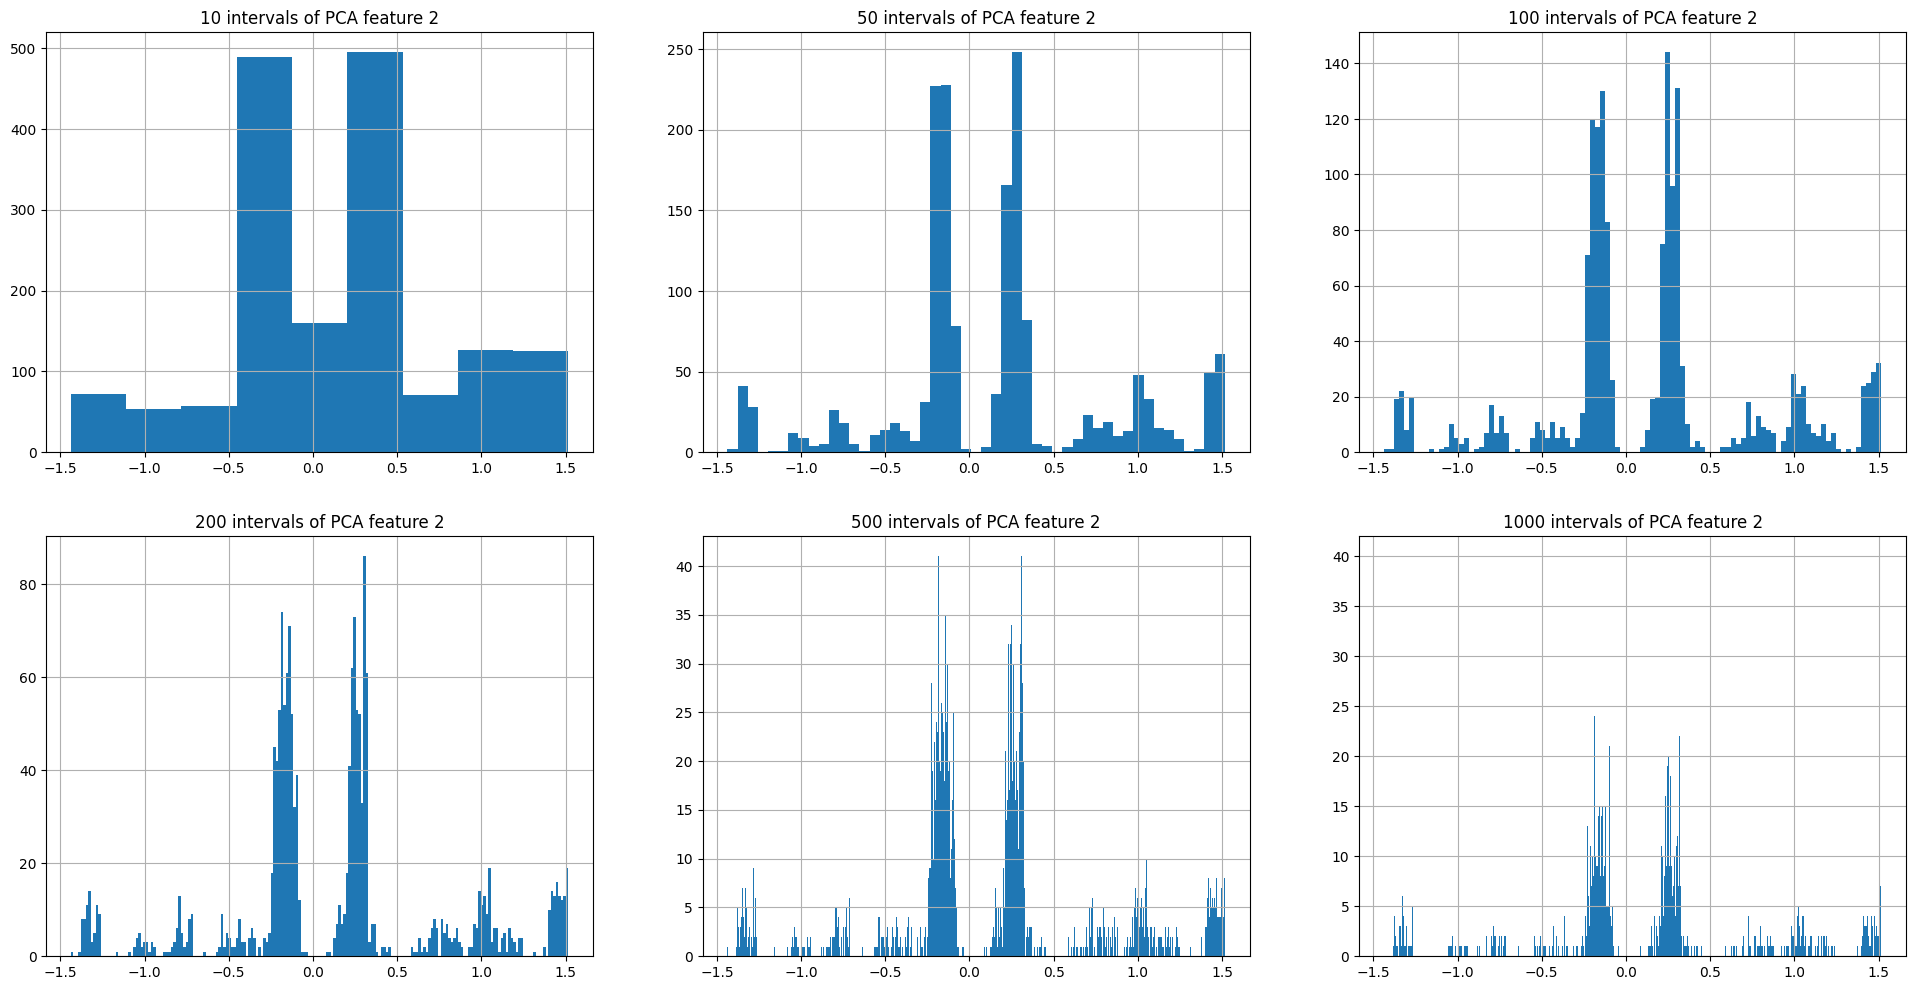

In [40]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 2

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

### Thành phần chính 2

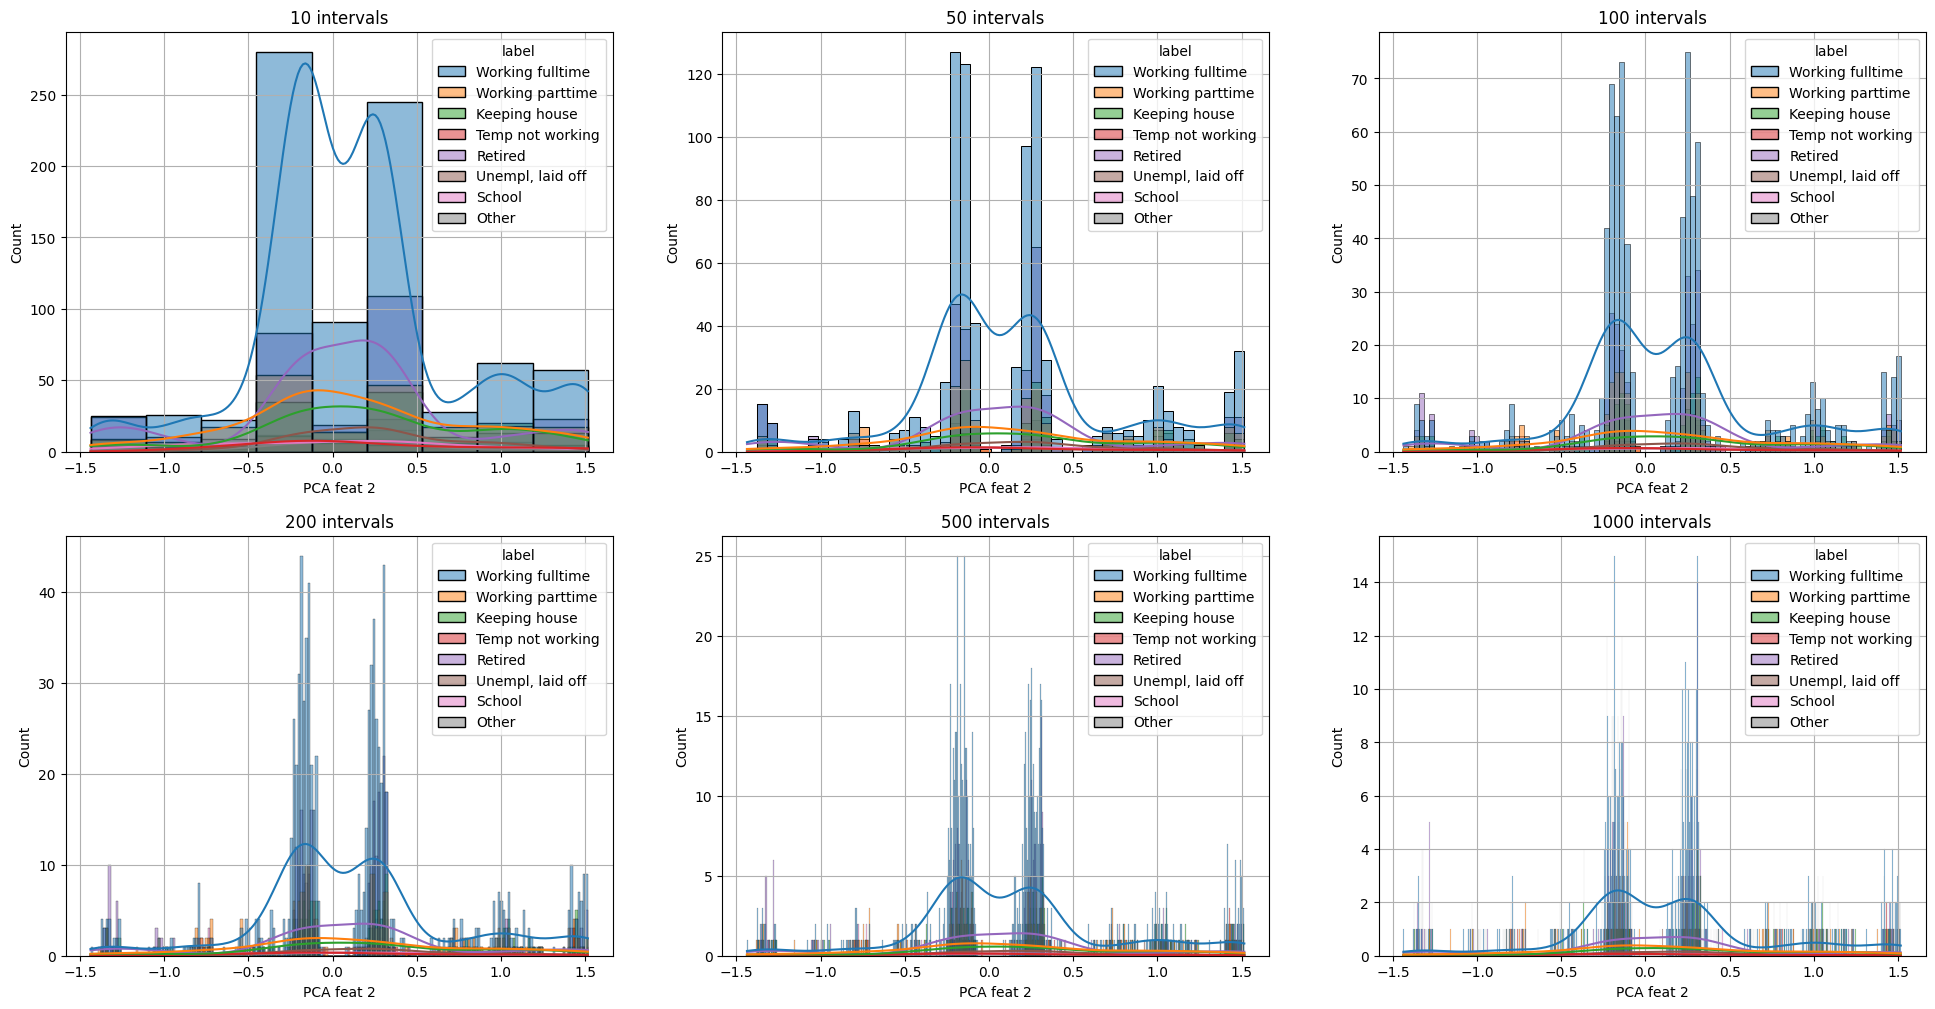

In [41]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 2

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

### Boxplot của các thành phần chính tương ứng với từng giá trị trong trường wrkstat

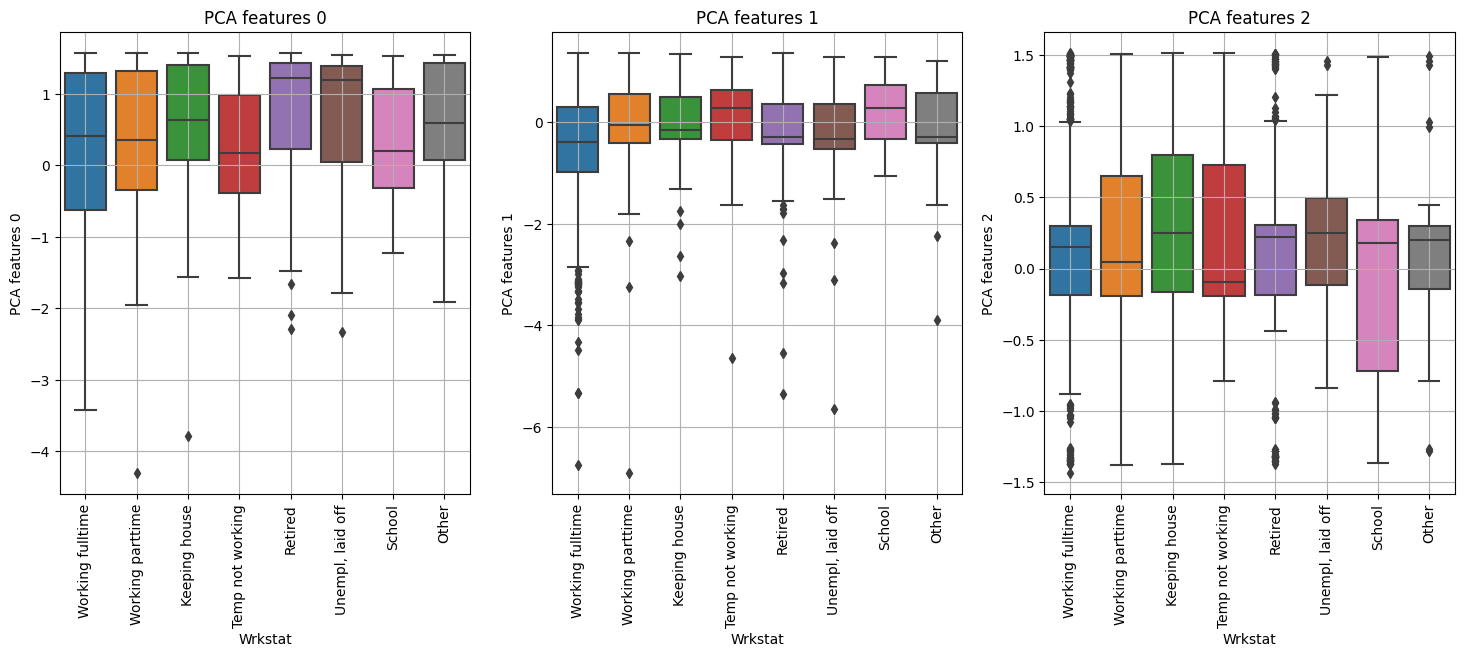

In [42]:
cols = 3
dims = [0, 1, 2]
rows = math.ceil(len(dims)/cols)
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
for i, dim in enumerate(dims):
    dominant_dim = reduced_x[:, dim]
    temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA features {}".format(dim))
    sns.boxplot( x='label', y="PCA feat {}".format(dim), data=temp_df)
    ax.set_ylabel("PCA features {}".format(dim))
    ax.set_xlabel('Wrkstat')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid()

### Vẽ scatter plot của các điểm dữ liệu theo các thành phần chính, màu sắc thể hiện giá trị của trường wrkstat

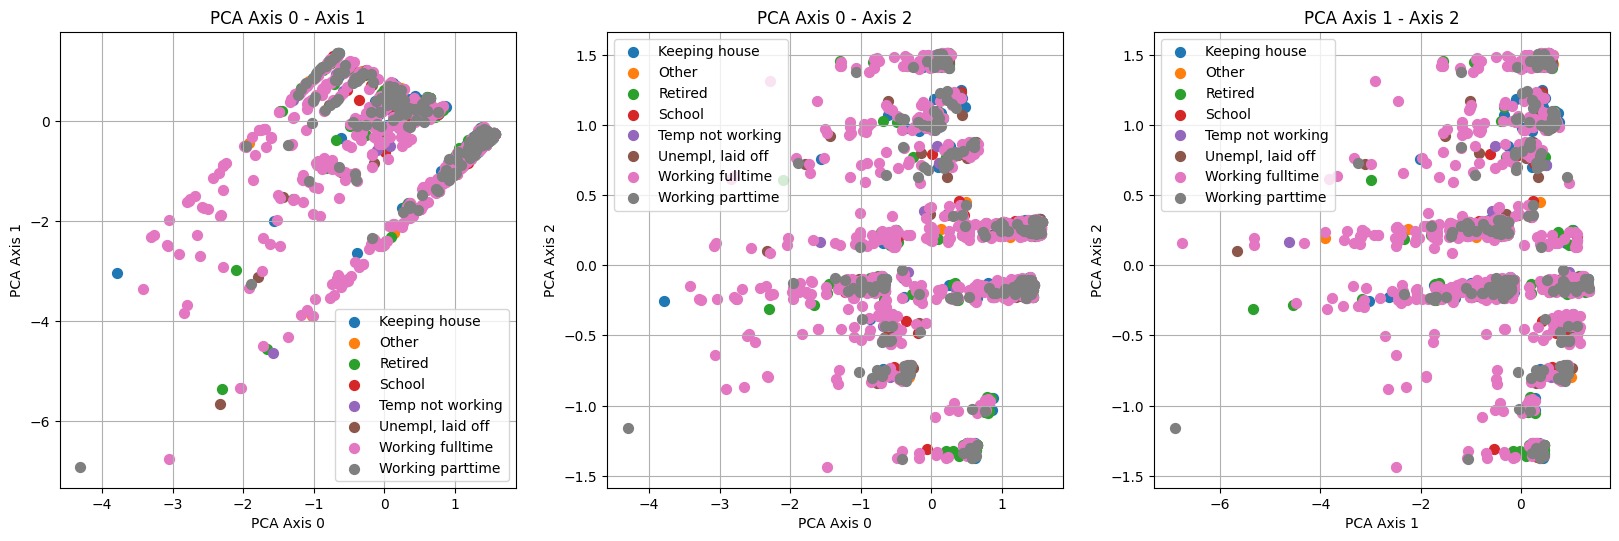

In [43]:
fig = plt.figure(figsize=(20, 20), facecolor='w')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.1)
nums = len(list(combinations(range(reduced_x.shape[1]), r=2)))
cols = 3
rows = math.ceil(nums/cols)
i = 0

#fig, ax = plt.subplots(rows, cols)
for couple in combinations(range(reduced_x.shape[1]), r=2):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA Axis {} - Axis {}".format(couple[0], couple[1]))
    x_ax = reduced_x[:, couple[0]]
    y_ax = reduced_x[:, couple[1]]
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x_ax[ix], y_ax[ix], label=g, s=50)

    ax.set_xlabel("PCA Axis {}".format(couple[0]))
    ax.set_ylabel("PCA Axis {}".format(couple[1]))
    ax.set_aspect(abs((x_ax.max() - x_ax.min())/(y_ax.max() - y_ax.min()))*1.0)
    ax.grid()
    ax.legend()
    i += 1

### Ta sử dụng DBSCAN để phân cụm sơ bộ các điểm dữ liệu, màu sắc thể hiện cụm mà điểm dữ liệu được chỉ định vào, ta sẽ xem đây là nhãn giả của dữ liệu

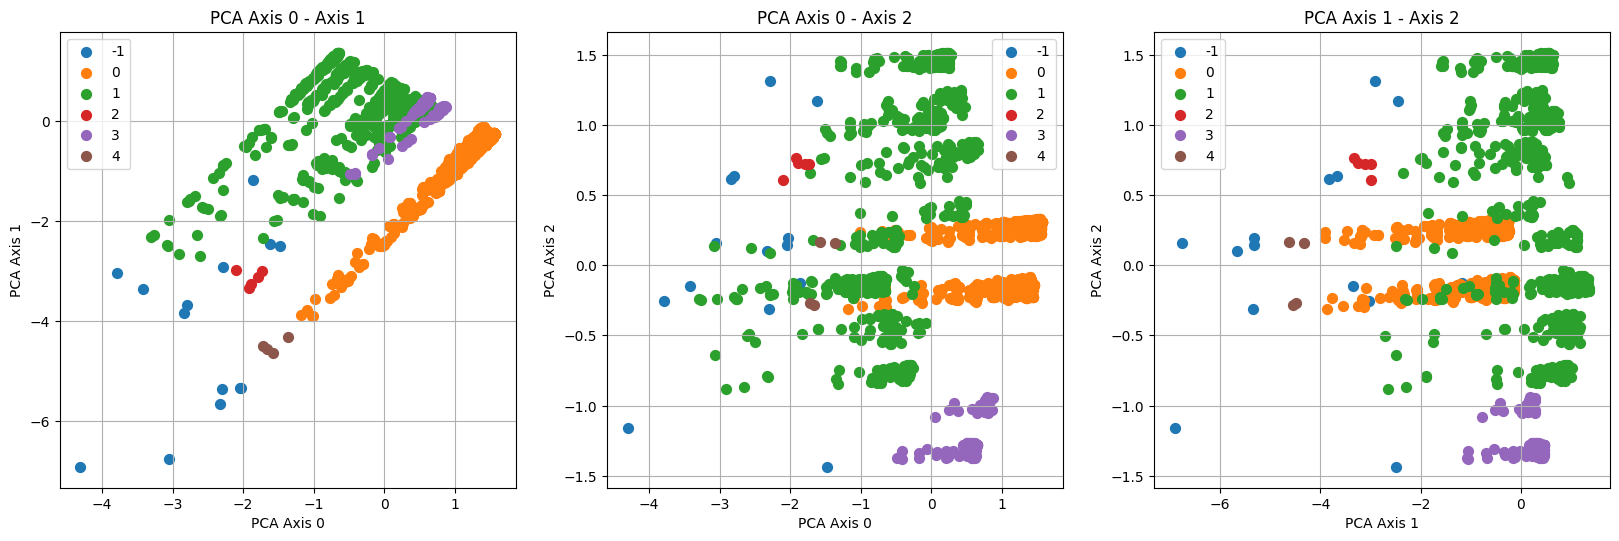

In [44]:
# clustering = DBSCAN(eps=0.55, min_samples=4).fit(reduced_x)
clustering = DBSCAN(eps=0.50, min_samples=4).fit(reduced_x)
#clustering = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(reduced_x)
clus_label = clustering.labels_

fig = plt.figure(figsize=(20, 20), facecolor='w')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
nums = len(list(combinations(range(reduced_x.shape[1]), r=2)))
cols = 3
rows = math.ceil(nums/cols)
i = 0

#fig, ax = plt.subplots(rows, cols)
for couple in combinations(range(reduced_x.shape[1]), r=2):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA Axis {} - Axis {}".format(couple[0], couple[1]))
    x_ax = reduced_x[:, couple[0]]
    y_ax = reduced_x[:, couple[1]]
    for g in np.unique(clus_label):
        ix = np.where(clus_label == g)
        ax.scatter(x_ax[ix], y_ax[ix], label=g, s=50)

    ax.set_xlabel("PCA Axis {}".format(couple[0]))
    ax.set_ylabel("PCA Axis {}".format(couple[1]))
    ax.set_aspect(abs((x_ax.max() - x_ax.min())/(y_ax.max() - y_ax.min()))*1.0)
    ax.grid()
    ax.legend()
    i += 1

# Ta sẽ xây dựng các mô hình phân loại với nhãn là nhãn giả từ quá trình phân cụm

# Lositic Regression của feature thu được từ PCA

### Phân chia tập dữ liệu

In [45]:
X_train, X_test, y_train, y_test = train_test_split(np.real(reduced_x), clus_label, test_size=0.4, random_state=42)

### Học mô hình Logistic

In [46]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [47]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.40      0.50      0.44         4
           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       272
           2       0.00      0.00      0.00         2
           3       0.97      1.00      0.99        36
           4       0.00      0.00      0.00         1

    accuracy                           0.99       660
   macro avg       0.56      0.58      0.57       660
weighted avg       0.99      0.99      0.99       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Tính AIC, BIC

In [48]:
aic = one_step_compute_aic(model=model, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=model, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(50.894885382669806, 64.37160488773122)

### Hàm vẽ ma trận nhầm lẫn

In [49]:
def plot_confusion_matrix(y_test, y_pred, classes, title="Confustion matrix"):
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)

    # Add legends for the heatmap
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()




### Ma trận nhầm lẫn cho tập test

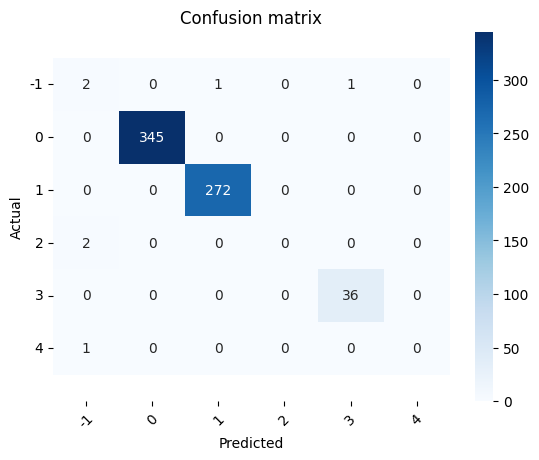

In [50]:

classes = np.unique(clus_label)
title = 'Confusion matrix'

plot_confusion_matrix(y_test, y_pred, classes=classes, title=title)

### List là danh sách các đặc trưng được đưa vào mô hình

In [51]:
features_list = df_encoded.columns.tolist()
features_list.remove('wrkstat')
len(features_list), features_list

(43,
 ['emailtotal',
  'harass5_0',
  'harass5_1',
  'harass5_2',
  'harass5_3',
  'snapchat_0',
  'snapchat_1',
  'snapchat_2',
  'instagrm_0',
  'instagrm_1',
  'instagrm_2',
  'polviews_0',
  'polviews_1',
  'polviews_2',
  'polviews_3',
  'polviews_4',
  'polviews_5',
  'polviews_6',
  'polviews_7',
  'advfront_0',
  'advfront_1',
  'advfront_2',
  'advfront_3',
  'advfront_4',
  'advfront_5',
  'educ_2',
  'educ_4',
  'educ_5',
  'educ_6',
  'educ_7',
  'educ_8',
  'educ_9',
  'educ_10',
  'educ_11',
  'educ_12',
  'educ_13',
  'educ_14',
  'educ_15',
  'educ_16',
  'educ_17',
  'educ_18',
  'educ_19',
  'educ_20'])

### Từ điển ánh xạ chỉ số thành tên đặc trưng

In [52]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'emailtotal',
 1: 'harass5_0',
 2: 'harass5_1',
 3: 'harass5_2',
 4: 'harass5_3',
 5: 'snapchat_0',
 6: 'snapchat_1',
 7: 'snapchat_2',
 8: 'instagrm_0',
 9: 'instagrm_1',
 10: 'instagrm_2',
 11: 'polviews_0',
 12: 'polviews_1',
 13: 'polviews_2',
 14: 'polviews_3',
 15: 'polviews_4',
 16: 'polviews_5',
 17: 'polviews_6',
 18: 'polviews_7',
 19: 'advfront_0',
 20: 'advfront_1',
 21: 'advfront_2',
 22: 'advfront_3',
 23: 'advfront_4',
 24: 'advfront_5',
 25: 'educ_2',
 26: 'educ_4',
 27: 'educ_5',
 28: 'educ_6',
 29: 'educ_7',
 30: 'educ_8',
 31: 'educ_9',
 32: 'educ_10',
 33: 'educ_11',
 34: 'educ_12',
 35: 'educ_13',
 36: 'educ_14',
 37: 'educ_15',
 38: 'educ_16',
 39: 'educ_17',
 40: 'educ_18',
 41: 'educ_19',
 42: 'educ_20'}

### Từ điển biến chỉ số thành tên đặc trưng dễ đọc hơn

In [53]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'emailtotal',
 1: 'harass5_Unknown',
 2: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 3: 'harass5_No',
 4: 'harass5_Yes',
 5: 'snapchat_Unknown',
 6: 'snapchat_No',
 7: 'snapchat_Yes',
 8: 'instagrm_Unknown',
 9: 'instagrm_No',
 10: 'instagrm_Yes',
 11: 'polviews_Unknown',
 12: 'polviews_Extrmly_conservative',
 13: 'polviews_Conservative',
 14: 'polviews_Slghtly_conservative',
 15: 'polviews_Moderate',
 16: 'polviews_Slightly_liberal',
 17: 'polviews_Liberal',
 18: 'polviews_Extremely_liberal',
 19: 'advfront_Unknown',
 20: 'advfront_Strongly_disagree',
 21: 'advfront_Disagree',
 22: 'advfront_Dont_know',
 23: 'advfront_Agree',
 24: 'advfront_Strongly_agree',
 25: 'educ_2',
 26: 'educ_4',
 27: 'educ_5',
 28: 'educ_6',
 29: 'educ_7',
 30: 'educ_8',
 31: 'educ_9',
 32: 'educ_10',
 33: 'educ_11',
 34: 'educ_12',
 35: 'educ_13',
 36: 'educ_14',
 37: 'educ_15',
 38: 'educ_16',
 39: 'educ_17',
 40: 'educ_18',
 41: 'educ_19',
 42: 'educ_20'}

### Tên các nhãn giả từ kế quả phân cụm

In [54]:
pseudo_label = np.unique(clus_label)
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

### Biến đổi weights của mô hình PCA thành weight của các đặc trưng ban đầu

In [55]:
original_weights = model.coef_.dot(U.T)
# original_weights = model.coef_.dot(pca.components_)

### Lấy k feature có trị tuyệt đối của weight cao nhất

In [56]:
top_k_features = 5

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [57]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{-1: {'emailtotal': 1.405,
  'snapchat_Unknown': -0.576,
  'instagrm_Unknown': -0.576,
  'snapchat_No': 0.519,
  'instagrm_No': 0.456},
 0: {'snapchat_Unknown': 1.787,
  'instagrm_Unknown': 1.787,
  'advfront_Unknown': -1.546,
  'harass5_Unknown': 1.541,
  'snapchat_No': -1.422},
 1: {'snapchat_Unknown': -1.962,
  'instagrm_Unknown': -1.962,
  'snapchat_No': 1.76,
  'instagrm_No': 1.591,
  'emailtotal': -0.983},
 2: {'emailtotal': 0.687,
  'snapchat_Unknown': -0.555,
  'instagrm_Unknown': -0.555,
  'snapchat_No': 0.541,
  'instagrm_No': 0.47},
 3: {'advfront_Agree': -1.503,
  'harass5_Unknown': -1.477,
  'advfront_Unknown': 1.473,
  'harass5_No': 1.281,
  'snapchat_No': -1.175},
 4: {'emailtotal': 0.848,
  'instagrm_Unknown': 0.25,
  'snapchat_Unknown': 0.25,
  'snapchat_No': -0.223,
  'instagrm_No': -0.207}}

### Hàm vẽ các biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

In [58]:
def plot_bar_importance(importance):
    fig = plt.figure(figsize=(20, 20), facecolor='w')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    nums = len(importance)
    cols = 3
    rows = math.ceil(nums/cols)
    i = 0

    for cls in importance:
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title("Feature importance of class {}".format(cls))
        ax.bar(importance[cls].keys(), np.abs(list(importance[cls].values())))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend()
        ax.grid()
        i += 1

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose la

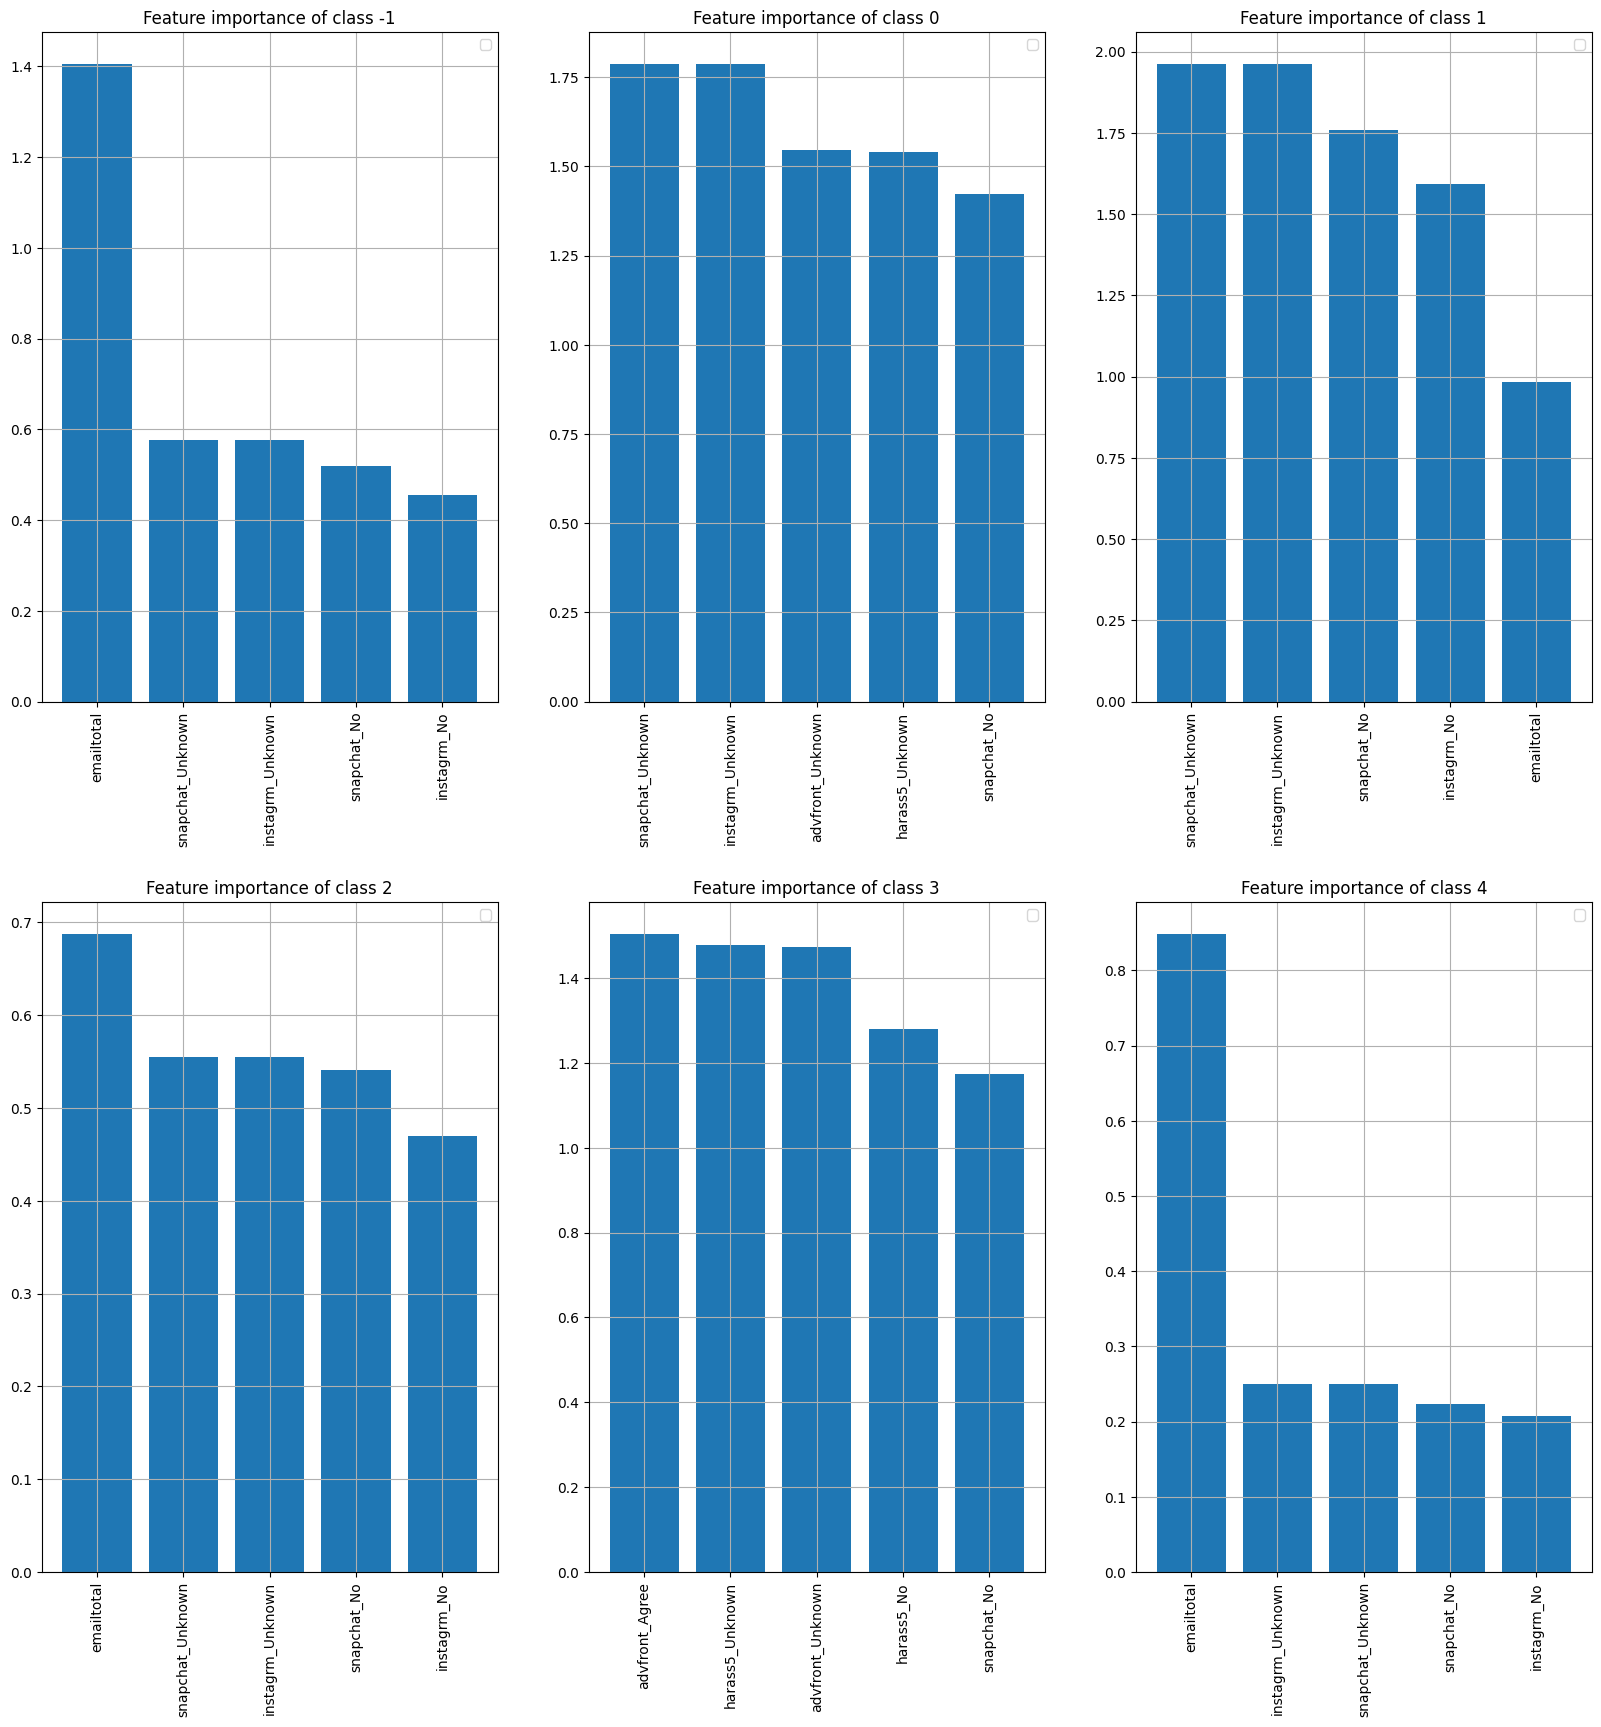

In [59]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

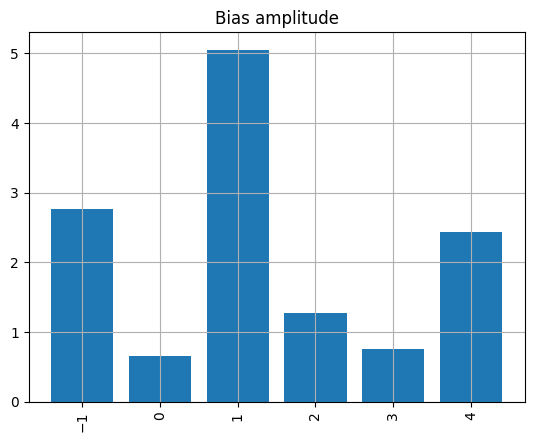

In [60]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()

# Logistic Regression của Feature gốc

### Ta phân chi dữ liệu thành tập train và tập test nhưng trên các đặc trưng gốc

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x, clus_label, test_size=0.4, random_state=42)

### Huấn luyện mô hình logistic

In [62]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [63]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         4
           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       272
           2       1.00      1.00      1.00         2
           3       0.97      1.00      0.99        36
           4       0.00      0.00      0.00         1

    accuracy                           1.00       660
   macro avg       0.83      0.75      0.77       660
weighted avg       0.99      1.00      0.99       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Tính AIC, BIC

In [64]:
aic = one_step_compute_aic(model=model, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=model, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(121.16662257621618, 314.33293548209645)

### Ma trận nhầm lẫn cho tập test

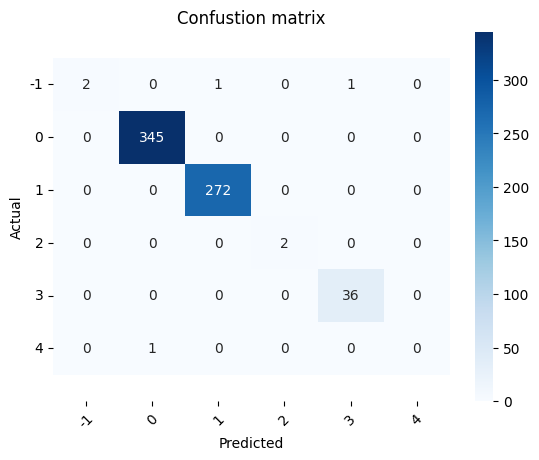

In [65]:
classes = np.unique(clus_label)
plot_confusion_matrix(y_test, y_pred, classes=classes)

### weight của các đặc trưng

In [66]:
original_weights = model.coef_

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [67]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{-1: {'emailtotal': 1.21,
  'snapchat_No': 0.89,
  'snapchat_Yes': -0.798,
  'educ_14': 0.675,
  'educ_18': 0.584},
 0: {'harass5_Unknown': 1.754,
  'snapchat_Unknown': 1.656,
  'instagrm_Unknown': 1.656,
  'advfront_Unknown': -1.617,
  'snapchat_No': -0.943},
 1: {'snapchat_Unknown': -1.879,
  'instagrm_Unknown': -1.879,
  'instagrm_No': 1.574,
  'snapchat_No': 1.33,
  'snapchat_Yes': 1.127},
 2: {'snapchat_Yes': 0.882,
  'instagrm_Unknown': -0.608,
  'snapchat_Unknown': -0.608,
  'emailtotal': 0.589,
  'educ_8': 0.487},
 3: {'advfront_Unknown': 1.717,
  'harass5_Unknown': -1.609,
  'snapchat_Unknown': 1.063,
  'instagrm_Unknown': 1.063,
  'harass5_No': 0.949},
 4: {'emailtotal': 0.787,
  'polviews_Slightly_liberal': 0.543,
  'educ_14': -0.468,
  'polviews_Moderate': -0.387,
  'educ_17': 0.381}}

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_15096\524778485.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose la

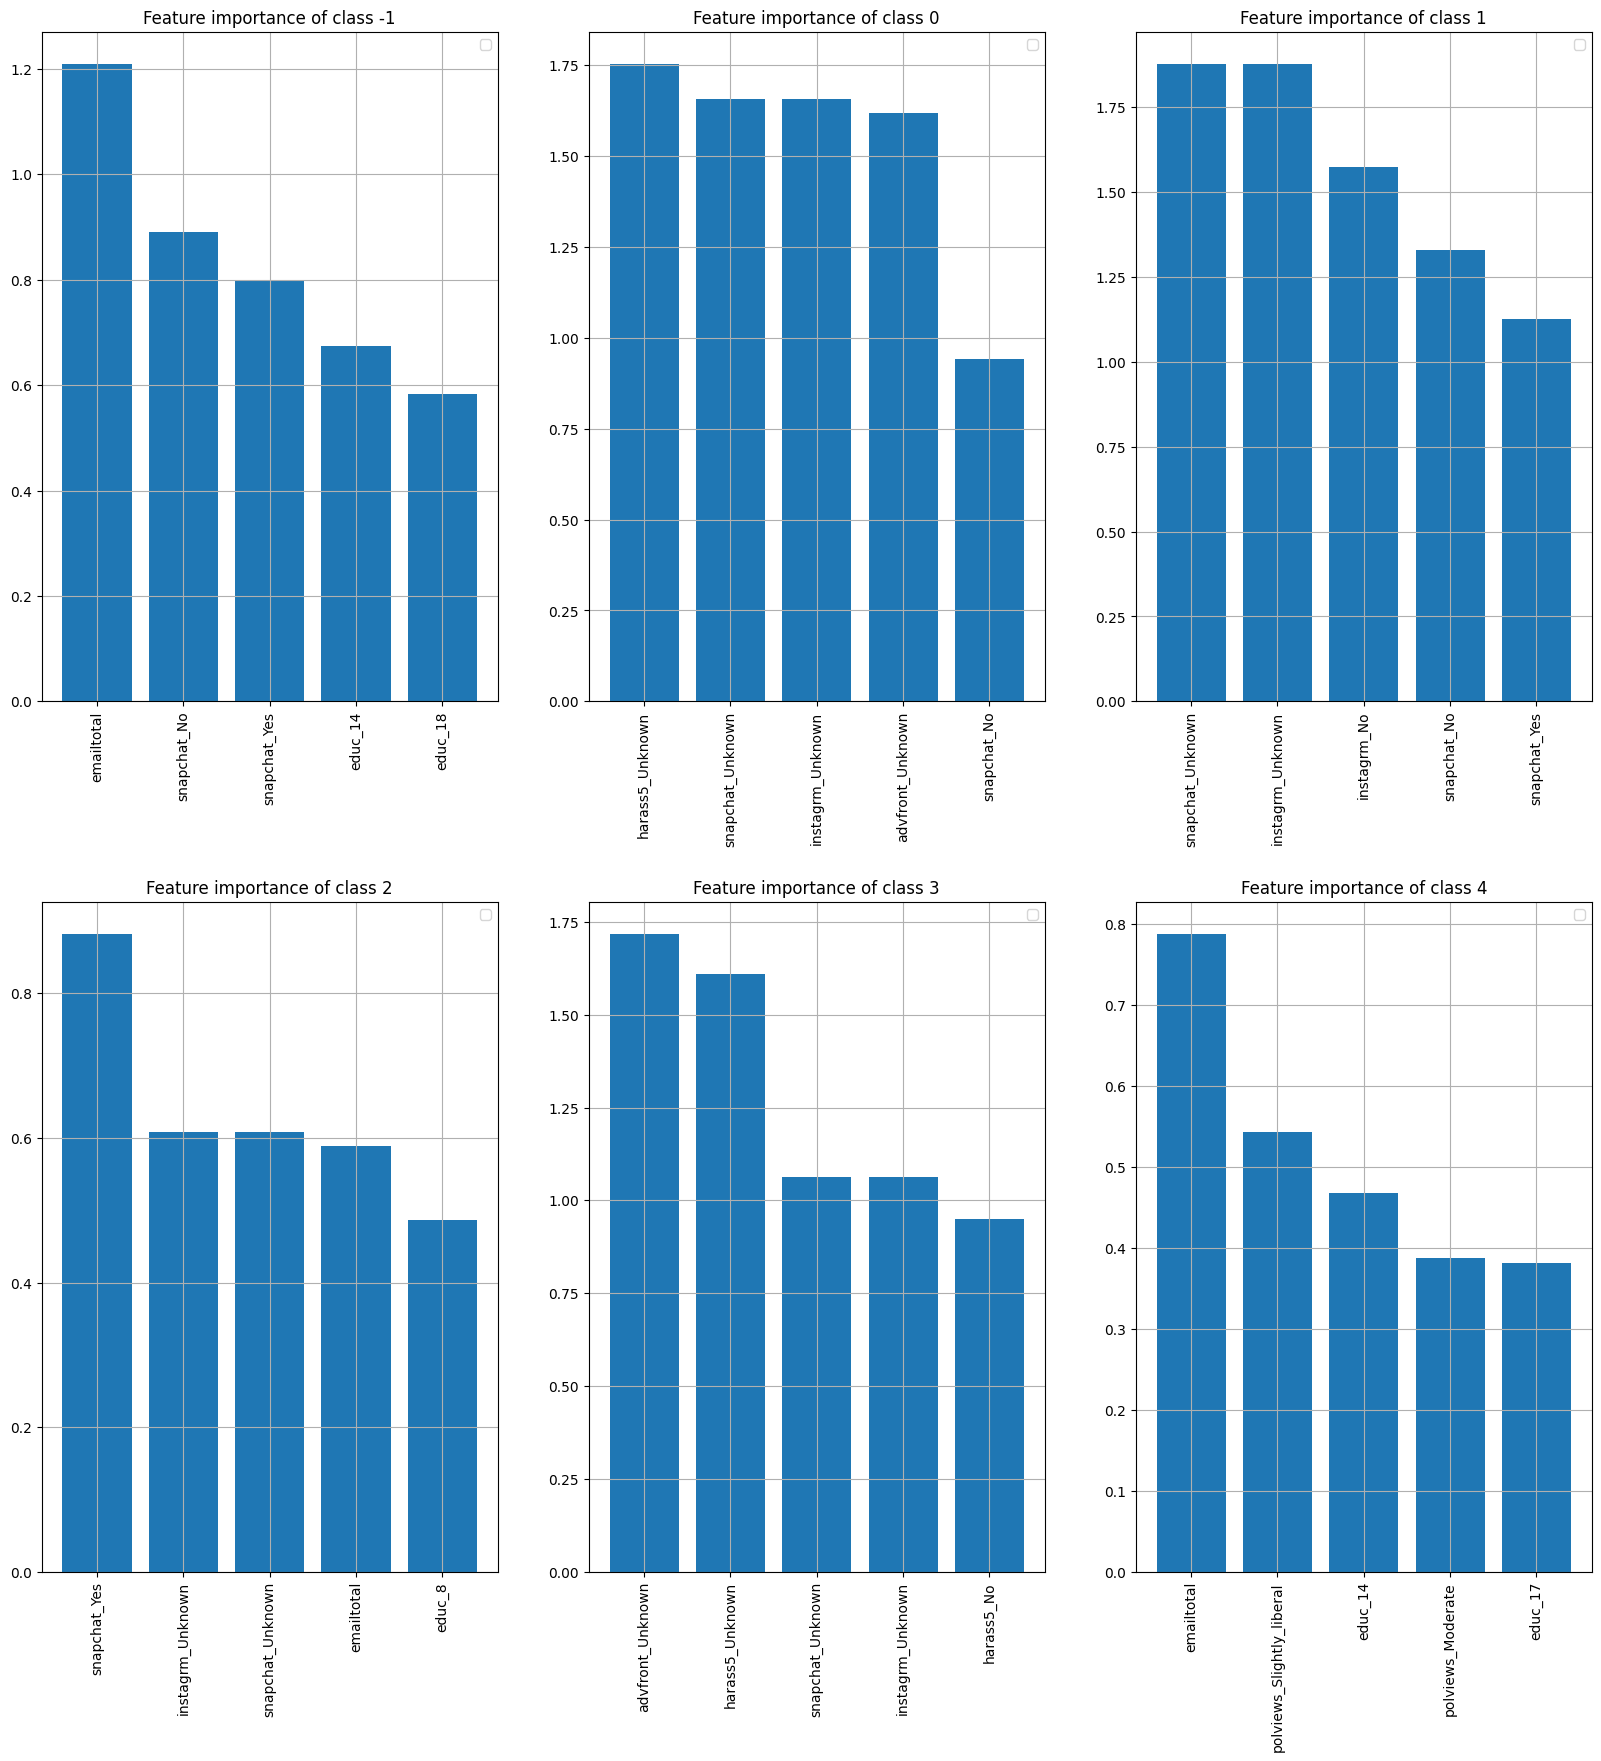

In [68]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

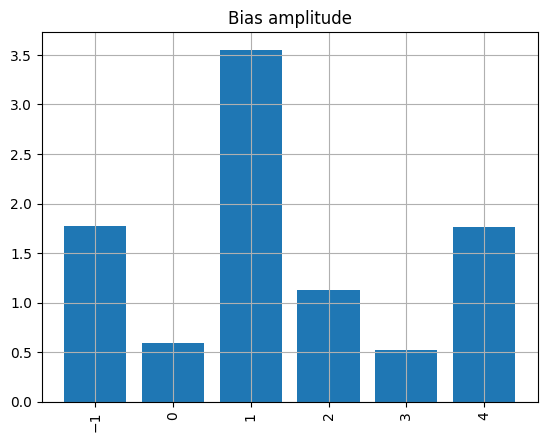

In [69]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()

# Random Forest từ feature thu được từ PCA

### Phân chia tập dữ liệu

In [70]:
X_train, X_test, y_train, y_test = train_test_split(np.real(reduced_x), clus_label, test_size=0.4, random_state=42)

### Học mô hình Random Forest

In [71]:
rdf_clf = RandomForestClassifier(
    max_depth = 3,
    max_leaf_nodes = 16,
    min_samples_split = 10,
    min_samples_leaf = 10,
    criterion='entropy',
    n_estimators=200
)
rdf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=16,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=200)

### Kết quả huấn luyện mô hình

In [72]:
y_pred = rdf_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.99      1.00      1.00       345
           1       0.98      1.00      0.99       272
           2       0.00      0.00      0.00         2
           3       0.95      1.00      0.97        36
           4       0.00      0.00      0.00         1

    accuracy                           0.99       660
   macro avg       0.49      0.50      0.49       660
weighted avg       0.98      0.99      0.98       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Tính AIC, BIC

In [73]:
aic = one_step_compute_aic(model=rdf_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=rdf_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\ensemble\_forest.py:922: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


(184.42543743477677, 197.9021569398382)

### Ma trận nhầm lẫn cho tập test

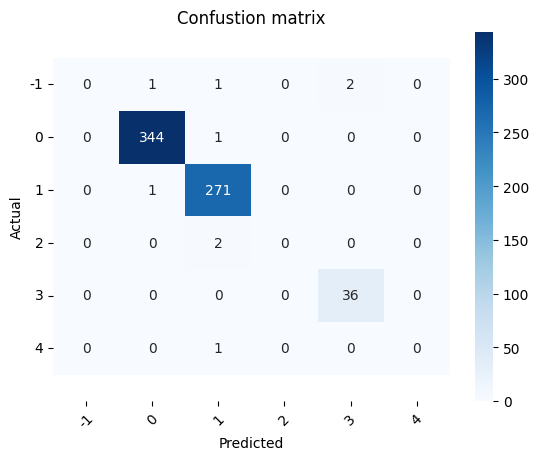

In [74]:
plot_confusion_matrix(y_test, y_pred, classes)

In [75]:
rdf_clf.feature_importances_

array([0.38349287, 0.37192068, 0.24458644])

### Biến đổi weights của mô hình PCA thành weight của các đặc trưng ban đầu

In [76]:
original_importance = U.dot(rdf_clf.feature_importances_)

### Lấy k feature có trị tuyệt đối của weight cao nhất

In [77]:
top_k_features = 10

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [78]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [79]:
importance

{'emailtotal': -0.527,
 'advfront_Agree': 0.126,
 'harass5_Unknown': 0.125,
 'advfront_Unknown': -0.124,
 'harass5_No': -0.106,
 'snapchat_No': 0.047,
 'instagrm_No': 0.039,
 'educ_12': 0.036,
 'educ_16': -0.031,
 'snapchat_Yes': -0.026}

### Biểu đồ cột các weight của các đặc trưng

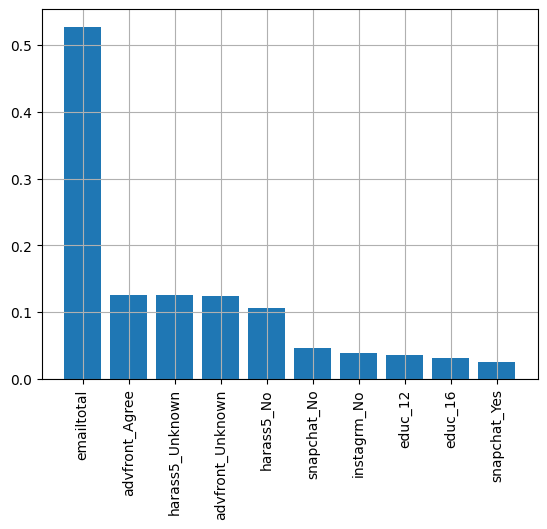

In [80]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()

# Random Forest thu được từ feature gốc

### Phân chia tập dữ liệu

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x, clus_label, test_size=0.4, random_state=42)

### Học mô hình Random Forest


In [82]:
rdf_clf = RandomForestClassifier(
    max_depth = 3,
    max_leaf_nodes = 16,
    min_samples_split = 10,
    min_samples_leaf = 10,
    criterion='entropy',
    n_estimators=200
)
rdf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=16,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=200)

### Kết quả huấn luyện mô hình

In [83]:
y_pred = rdf_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.96      1.00      0.98       345
           1       0.99      1.00      0.99       272
           2       0.00      0.00      0.00         2
           3       0.96      0.67      0.79        36
           4       0.00      0.00      0.00         1

    accuracy                           0.97       660
   macro avg       0.48      0.44      0.46       660
weighted avg       0.96      0.97      0.96       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Tính AIC, BIC

In [84]:
aic = one_step_compute_aic(model=rdf_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=rdf_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(332.221792986213, 525.3881058920932)

### Ma trận nhầm lẫn cho tập test

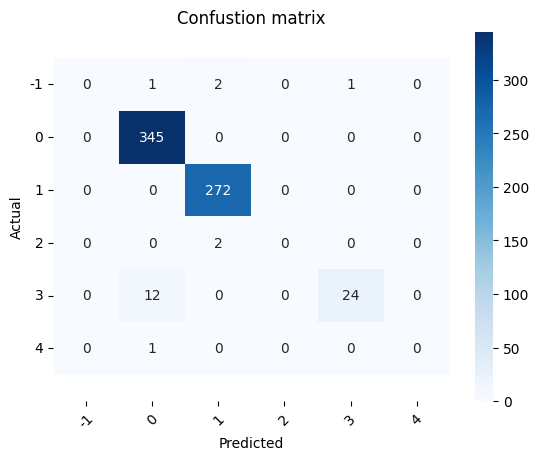

In [85]:
plot_confusion_matrix(y_test, y_pred, classes)

weight của các đặc trưng

In [86]:
original_importance = rdf_clf.feature_importances_

### Trọng số của các đặc trưng cao nhất

In [87]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [88]:
importance

{'instagrm_Unknown': 0.316,
 'snapchat_Unknown': 0.149,
 'harass5_Unknown': 0.098,
 'snapchat_No': 0.095,
 'instagrm_No': 0.094,
 'advfront_Unknown': 0.07,
 'harass5_No': 0.051,
 'instagrm_Yes': 0.047,
 'snapchat_Yes': 0.034,
 'emailtotal': 0.018}

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

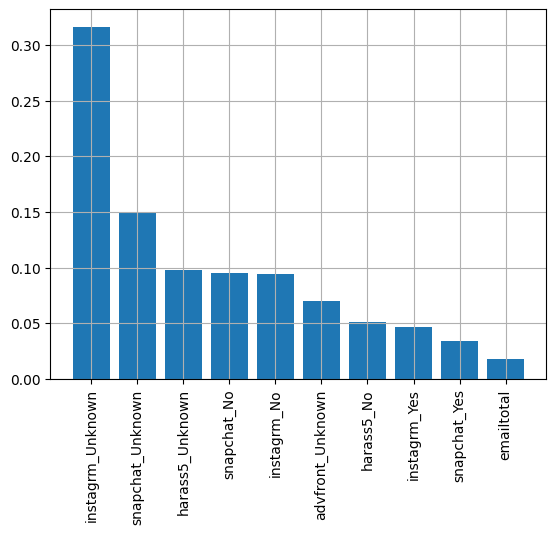

In [89]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()

# AdaBoost với feature thu được từ PCA

### Phân chia tập dữ liệu

In [90]:
X_train, X_test, y_train, y_test = train_test_split(np.real(reduced_x), clus_label, test_size=0.4, random_state=42)

### Học mô hình AdaBoost

In [91]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

### Kết quả huấn luyện mô hình

In [92]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.75      0.75      0.75         4
           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       272
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00         1

    accuracy                           1.00       660
   macro avg       0.96      0.96      0.96       660
weighted avg       1.00      1.00      1.00       660



### Tính AIC, BIC

In [93]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(33.150014490910976, 46.626733995972394)

### Ma trận nhầm lẫn cho tập test

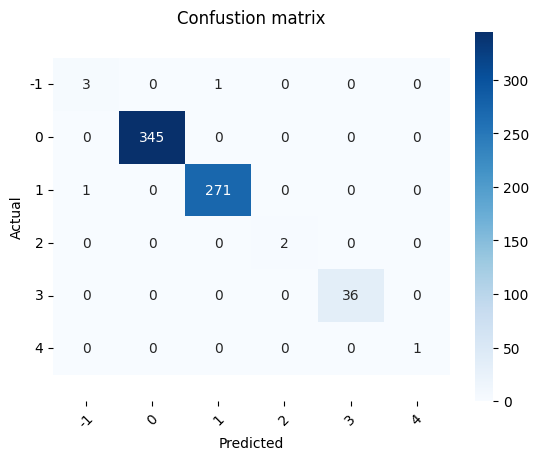

In [94]:
plot_confusion_matrix(y_test, y_pred, classes)

### Biến đổi weights của mô hình PCA thành weight của các đặc trưng ban đầu

In [95]:
original_importance = U.dot(ada_clf.feature_importances_)
ada_clf.feature_importances_

array([0.42491951, 0.30791579, 0.2671647 ])

### Trọng số của các đặc trưng cao nhất

In [96]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [97]:
importance

{'emailtotal': -0.5,
 'harass5_Unknown': 0.158,
 'advfront_Unknown': -0.157,
 'advfront_Agree': 0.15,
 'harass5_No': -0.134,
 'educ_12': 0.033,
 'snapchat_Yes': -0.032,
 'educ_16': -0.03,
 'snapchat_No': 0.029,
 'instagrm_Yes': -0.024}

### Hàm vẽ các biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

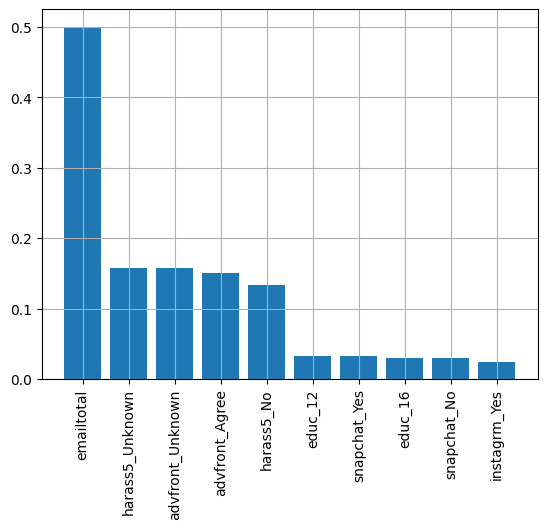

In [98]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()

# AdaBoost với feature gốc

### Phân chia tập dữ liệu

In [99]:
X_train, X_test, y_train, y_test = train_test_split(x, clus_label, test_size=0.4, random_state=42)

### Học mô hình AdaBoost

In [100]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
                             n_estimators=50,
                             algorithm="SAMME.R",
                             learning_rate=1.0)
# ada_clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial'),
#                              n_estimators=20,
#                              algorithm="SAMME.R",
#                              learning_rate=1.0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

### Kết quả huấn luyện mô hình

In [101]:
y_pred = ada_clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         4
           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       272
           2       1.00      1.00      1.00         2
           3       0.97      1.00      0.99        36
           4       1.00      1.00      1.00         1

    accuracy                           1.00       660
   macro avg       0.99      0.92      0.94       660
weighted avg       1.00      1.00      1.00       660



### Tính AIC, BIC

In [102]:
aic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test)
bic = one_step_compute_aic(model=ada_clf, x_test=X_test, y_test=y_test, type="bic")

aic, bic

(129.37807631137184, 322.5443892172521)

### Ma trận nhầm lẫn cho tập test

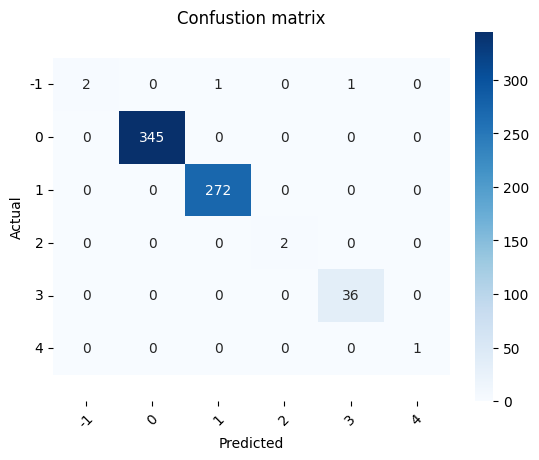

In [103]:
plot_confusion_matrix(y_test, y_pred, classes)

### weight của các đặc trưng ban đầu

In [104]:
original_importance = ada_clf.feature_importances_
original_importance

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\tree\_classes.py:666: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


array([           nan, 5.05436393e-02, 0.00000000e+00, 2.01756259e-02,
       1.56471891e-02, 7.73465443e-02, 4.10958134e-02, 6.50256517e-02,
       9.03429320e-02, 8.72356167e-03, 6.58833328e-03, 1.20093668e-02,
       0.00000000e+00, 5.13627260e-03, 0.00000000e+00, 5.42601289e-06,
       1.76954238e-02, 1.28924288e-02, 0.00000000e+00, 4.87172307e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18950681e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.51092376e-18, 0.00000000e+00, 4.81598765e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.52061857e-03, 1.07678588e-04,
       3.65515112e-02, 2.18320451e-17, 1.67182264e-02, 0.00000000e+00,
       3.03535838e-02, 2.84151292e-03, 5.88635191e-03])

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [105]:
importance = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_importance))[::-1][:top_k_features]), np.round(original_importance[np.argsort(np.abs(original_importance))[::-1][:top_k_features]], 3)))

In [106]:
importance

{'emailtotal': nan,
 'instagrm_Unknown': 0.09,
 'snapchat_Unknown': 0.077,
 'snapchat_Yes': 0.065,
 'harass5_Unknown': 0.051,
 'advfront_Unknown': 0.049,
 'snapchat_No': 0.041,
 'educ_14': 0.037,
 'educ_18': 0.03,
 'harass5_No': 0.02}

### Hàm vẽ các biểu đồ cột các weight của các đặc trưng

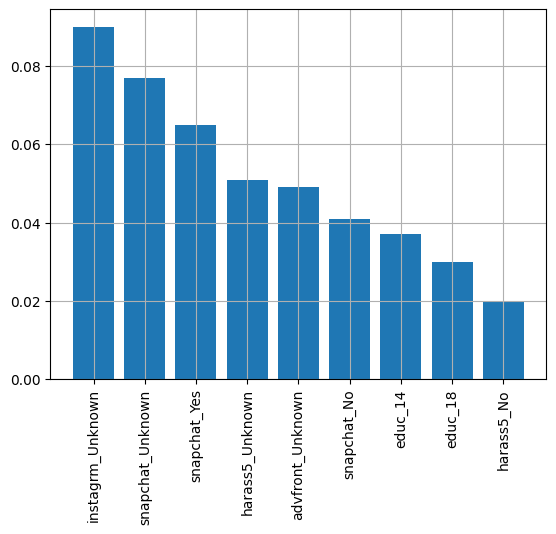

In [107]:
plt.bar(importance.keys(), np.abs(list(importance.values())))
plt.xticks(rotation=90)
plt.grid()
plt.show()